# Predicting German Power Prices



```
# Ce texte est au format code
```

Elyes Dahmane Bouali

## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.random import set_seed

import xgboost as xgb


from scipy.stats import probplot
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
set_seed(0)

## Summary

I : Data Preprocessing : I look at the dataset, try to eliminate outliers and deal with missing values

II : Building models : I build different models to predict day-ahead prices based on historical data
 - a) Linear regression because it's the simplest model
 - b) Rigde regression to improve performance
 - c) Random forest to perform feature selection and run Random Forest Regression
 - d) Linear regression with the selected feature
 - e) Neural Newtorks :
    - 1) LSTM model because they are good at capturing long-term dependencies
    - 2) XGBoost model because it's highly efficient and performant

III : Making predictions with the best model

## I : Data preprocessing

This is what the different csv file contains:
- Price: Day-ahead prices for German market.
- Productions: Hourly actual energy productions for different areas.
- Demand: Actual hourly consumption.
- Net Import: Net physical electricity flows from neighbor countries to Germany (import-export).
- Costs: Clean spark spread and clean dark spread.
- Weather: Average country temperature and wind speed.

In [ ]:
price=pd.read_csv('price.csv',index_col=0)
price.index = pd.to_datetime(price.index, utc=True, infer_datetime_format=True)
price

<ipython-input-6-2187a82daccc>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  price.index = pd.to_datetime(price.index, utc=True, infer_datetime_format=True)


,price
datetime,
2018-01-01 00:00:00+00:00,-5.27
2018-01-01 01:00:00+00:00,-29.99
2018-01-01 02:00:00+00:00,-56.65
2018-01-01 03:00:00+00:00,-63.14
2018-01-01 04:00:00+00:00,-64.62
...,...
2022-04-30 19:00:00+00:00,246.97
2022-04-30 20:00:00+00:00,252.64
2022-04-30 21:00:00+00:00,247.11


In [ ]:
production=pd.read_csv('production.csv',index_col=0)
production.index = pd.to_datetime(production.index, utc=True, infer_datetime_format=True)
production

<ipython-input-7-6268b5615f2c>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  production.index = pd.to_datetime(production.index, utc=True, infer_datetime_format=True)


,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore
datetime,,,,,,,,
2018-01-01 00:00:00+00:00,44.75,0.00,2882.50,1739.00,1711.00,5853.75,28660.25,2917.50
2018-01-01 01:00:00+00:00,46.75,0.00,2936.75,1629.50,1609.25,4754.00,30105.50,2999.25
2018-01-01 02:00:00+00:00,48.75,0.00,2903.50,1623.25,1683.25,4591.00,30772.75,3096.00
2018-01-01 03:00:00+00:00,45.00,0.00,2886.00,1613.25,1679.50,4888.75,31641.50,3136.75
2018-01-01 04:00:00+00:00,46.25,0.00,2898.50,1607.75,1677.50,4696.50,31529.00,3212.00
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00+00:00,267.25,4246.75,9930.50,1566.75,7355.75,3920.25,7795.50,969.00
2022-06-30 20:00:00+00:00,287.50,1304.75,9792.00,1579.75,7339.25,3925.00,9108.50,1058.25
2022-06-30 21:00:00+00:00,276.50,95.00,9783.25,1602.00,7238.50,3934.75,10182.75,1617.00


In [ ]:
net_imports=pd.read_csv('net_imports.csv',index_col=0)
net_imports.index = pd.to_datetime(net_imports.index, utc=True, infer_datetime_format=True)
net_imports

<ipython-input-8-84bb44c0c10f>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  net_imports.index = pd.to_datetime(net_imports.index, utc=True, infer_datetime_format=True)


,NetImport
Date,
2018-01-01 00:00:00+00:00,-14676.00
2018-01-01 01:00:00+00:00,-15591.00
2018-01-01 02:00:00+00:00,-15995.00
2018-01-01 03:00:00+00:00,-16235.00
2018-01-01 04:00:00+00:00,-15445.00
...,...
2022-06-29 19:00:00+00:00,3233.50
2022-06-29 20:00:00+00:00,4193.75
2022-06-29 21:00:00+00:00,3327.25


In [ ]:
costs=pd.read_csv('costs.csv',index_col=0)
costs.index = pd.to_datetime(costs.index, utc=True, infer_datetime_format=True)
costs

<ipython-input-9-358f601f7f6c>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  costs.index = pd.to_datetime(costs.index, utc=True, infer_datetime_format=True)


,Clean Spark Spread,Clean Dark Spread
date,,
2019-01-01 00:00:00+00:00,-59.93,-54.42
2019-01-02 00:00:00+00:00,-29.74,-24.50
2019-01-03 00:00:00+00:00,2.47,7.41
2019-01-04 00:00:00+00:00,-6.72,-0.40
2019-01-05 00:00:00+00:00,-13.48,-8.28
...,...,...
2022-06-26 00:00:00+00:00,-94.95,-5.13
2022-06-27 00:00:00+00:00,18.91,103.67
2022-06-28 00:00:00+00:00,31.05,117.66


In [ ]:
consumption=pd.read_csv('consumption.csv',index_col=0)
consumption.index = pd.to_datetime(consumption.index, utc=True, infer_datetime_format=True)
consumption

<ipython-input-10-272b8c66fdd8>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  consumption.index = pd.to_datetime(consumption.index, utc=True, infer_datetime_format=True)


,consumption
datetime,
2018-01-01 00:00:00+00:00,44877.75
2018-01-01 01:00:00+00:00,43816.50
2018-01-01 02:00:00+00:00,42820.00
2018-01-01 03:00:00+00:00,42051.75
2018-01-01 04:00:00+00:00,42061.50
...,...
2022-06-30 19:00:00+00:00,60928.00
2022-06-30 20:00:00+00:00,59179.75
2022-06-30 21:00:00+00:00,57592.50


In [ ]:
weather=pd.read_csv('weather.csv',index_col=0)
weather.index = pd.to_datetime(weather.index, utc=True, infer_datetime_format=True)
weather

<ipython-input-11-deb3a25f4b39>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather.index = pd.to_datetime(weather.index, utc=True, infer_datetime_format=True)


,TEMPERATURE,WIND
datetime,,
2018-01-01 00:00:00+00:00,8.19,8.76
2018-01-01 01:00:00+00:00,7.85,8.77
2018-01-01 02:00:00+00:00,7.54,8.07
2018-01-01 03:00:00+00:00,7.29,8.93
2018-01-01 04:00:00+00:00,6.93,9.38
...,...,...
2022-06-30 19:00:00+00:00,27.54,3.35
2022-06-30 20:00:00+00:00,26.25,3.42
2022-06-30 21:00:00+00:00,22.91,3.79


We can see that the index of each data frame is different from the other ones so to have a final data frame that concatenates the different data frames I will keep the index of the day ahead prices as the benchmark index.

In [ ]:
production_re=production.reindex(price.index)
costs_re=costs.reindex(price.index)
consumption_re=consumption.reindex(price.index)
weather_re=weather.reindex(price.index)

In [ ]:
result_df=pd.concat([price,production_re,consumption_re,net_imports,costs_re,weather_re],axis=1)
result_df=result_df.loc[:'2022-04-30']
result_df

,price,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore,consumption,NetImport,Clean Spark Spread,Clean Dark Spread,TEMPERATURE,WIND
2018-01-01 00:00:00+00:00,-5.27,44.75,0.00,2882.50,1739.00,1711.00,5853.75,28660.25,2917.50,44877.75,-14676.00,NaN,NaN,8.19,8.76
2018-01-01 01:00:00+00:00,-29.99,46.75,0.00,2936.75,1629.50,1609.25,4754.00,30105.50,2999.25,43816.50,-15591.00,NaN,NaN,7.85,8.77
2018-01-01 02:00:00+00:00,-56.65,48.75,0.00,2903.50,1623.25,1683.25,4591.00,30772.75,3096.00,42820.00,-15995.00,NaN,NaN,7.54,8.07
2018-01-01 03:00:00+00:00,-63.14,45.00,0.00,2886.00,1613.25,1679.50,4888.75,31641.50,3136.75,42051.75,-16235.00,NaN,NaN,7.29,8.93
2018-01-01 04:00:00+00:00,-64.62,46.25,0.00,2898.50,1607.75,1677.50,4696.50,31529.00,3212.00,42061.50,-15445.00,NaN,NaN,6.93,9.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00+00:00,246.97,126.25,1869.00,4717.75,1107.50,6009.75,3955.75,4077.00,311.25,49792.25,5518.25,NaN,NaN,11.96,3.15
2022-04-30 20:00:00+00:00,252.64,95.50,175.75,4671.75,1109.25,6006.25,3956.00,4420.00,329.50,48783.00,5400.50,NaN,NaN,11.36,2.91
2022-04-30 21:00:00+00:00,247.11,81.50,0.25,4595.75,1111.00,5990.25,3956.75,4875.50,315.50,47183.00,3995.00,NaN,NaN,10.32,2.82
2022-04-30 22:00:00+00:00,239.09,84.00,0.00,4448.00,1122.75,5876.25,3958.25,4919.00,232.00,45426.00,3194.25,NaN,NaN,9.70,2.75


In [ ]:
result_df.describe().round(1)

,price,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore,consumption,NetImport,Clean Spark Spread,Clean Dark Spread,TEMPERATURE,WIND
count,37920.0,37920.0,37920.0,37920.0,37920.0,37920.0,37920.0,37920.0,37920.0,37920.0,37943.0,1215.0,1215.0,37920.0,37866.0
mean,61.9,129.4,5001.2,6119.3,1572.9,6031.2,7398.9,11299.8,2730.2,56869.0,-3296.4,-12.5,-5.7,9.9,4.8
std,62.5,90.5,7709.9,2623.1,341.4,3928.1,1463.8,9046.2,1854.8,9881.6,5330.3,34.3,40.5,7.5,2.0
min,-90.0,1.0,0.0,1209.8,783.5,738.2,2665.5,100.0,0.0,33142.0,-17807.0,-217.2,-117.5,-11.0,1.0
25%,32.0,59.0,0.0,3933.4,1309.5,2608.7,6562.2,4313.7,1022.4,48810.9,-7334.4,-15.8,-21.0,4.1,3.3
50%,44.2,103.2,130.9,5793.2,1559.2,5111.0,7744.2,8565.1,2585.4,56580.0,-3599.0,-3.1,-12.1,9.0,4.4
75%,63.8,179.5,7925.0,7924.8,1839.8,8778.3,8138.8,16025.3,4277.5,65208.9,571.5,3.2,-3.6,15.0,5.8
max,700.0,769.0,36175.2,15033.2,2385.2,17423.0,9524.0,44030.0,7230.8,81749.0,13805.0,119.2,303.9,36.7,15.8


In [ ]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37943 entries, 2018-01-01 00:00:00+00:00 to 2022-04-30 23:00:00+00:00
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               37920 non-null  float64
 1   Dam                 37920 non-null  float64
 2   Solar               37920 non-null  float64
 3   NaturalGas          37920 non-null  float64
 4   Ror                 37920 non-null  float64
 5   HardCoal            37920 non-null  float64
 6   Nuclear             37920 non-null  float64
 7   WindOnshore         37920 non-null  float64
 8   WindOffshore        37920 non-null  float64
 9   consumption         37920 non-null  float64
 10  NetImport           37943 non-null  float64
 11  Clean Spark Spread  1215 non-null   float64
 12  Clean Dark Spread   1215 non-null   float64
 13  TEMPERATURE         37920 non-null  float64
 14  WIND                37866 non-null  float64
dtypes: flo

Now I'm going to see if there are any NaNs and duplicates.

In [ ]:
print('There are {} missing values or NaNs '
      .format(result_df.isnull().values.sum()))

temp_energy = result_df.duplicated(keep='first').sum()

print('There are {} duplicate rows based on all columns.'
      .format(temp_energy))

There are 73786 missing values or NaNs 
There are 0 duplicate rows based on all columns.


The dataset has missing values or NaNs but I can't drop the rows with the missing values since I want to forecast the price of electricity.

In [ ]:
result_df.isnull().sum(axis=0)

,0
price,23
Dam,23
Solar,23
NaturalGas,23
Ror,23
HardCoal,23
Nuclear,23
WindOnshore,23
WindOffshore,23
consumption,23


The major part of the Null values is in the Spread columns. This is mainly due to the concatenation problem. To do so I'm only going to keep the dates from where I have data in these 2 columns.

The Wind column has also Nan values, I plot the time series.

In [ ]:
def plot_series(df=None, column=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

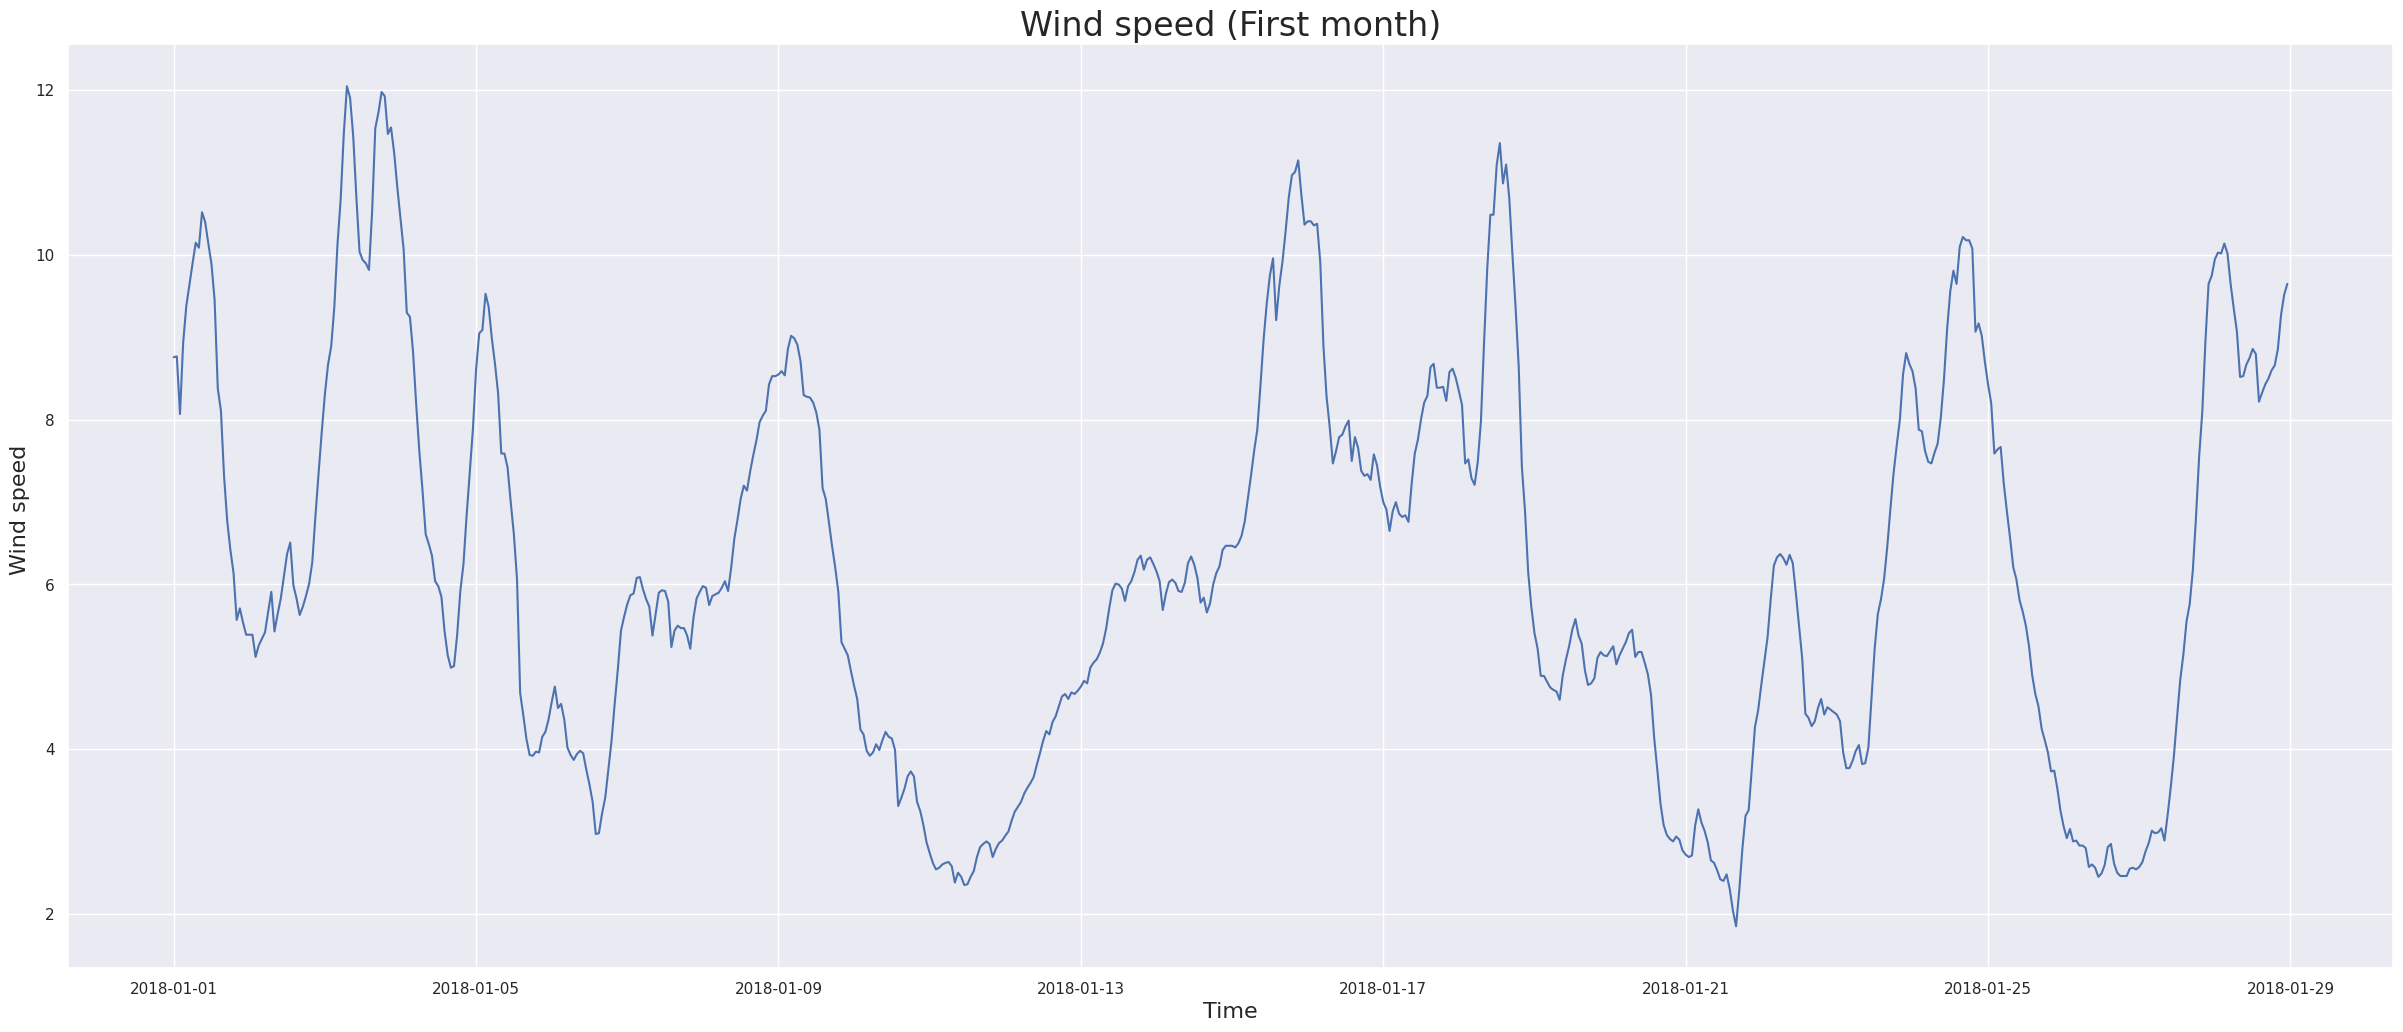

In [ ]:
ax = plot_series(df=result_df, column='WIND', ylabel='Wind speed ',
                 title='Wind speed (First month)', end=24*7*4)
plt.show()

In [ ]:
result_df[result_df.isnull().any(axis=1)]

,price,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore,consumption,NetImport,Clean Spark Spread,Clean Dark Spread,TEMPERATURE,WIND
2018-01-01 00:00:00+00:00,-5.27,44.75,0.00,2882.50,1739.00,1711.00,5853.75,28660.25,2917.50,44877.75,-14676.00,NaN,NaN,8.19,8.76
2018-01-01 01:00:00+00:00,-29.99,46.75,0.00,2936.75,1629.50,1609.25,4754.00,30105.50,2999.25,43816.50,-15591.00,NaN,NaN,7.85,8.77
2018-01-01 02:00:00+00:00,-56.65,48.75,0.00,2903.50,1623.25,1683.25,4591.00,30772.75,3096.00,42820.00,-15995.00,NaN,NaN,7.54,8.07
2018-01-01 03:00:00+00:00,-63.14,45.00,0.00,2886.00,1613.25,1679.50,4888.75,31641.50,3136.75,42051.75,-16235.00,NaN,NaN,7.29,8.93
2018-01-01 04:00:00+00:00,-64.62,46.25,0.00,2898.50,1607.75,1677.50,4696.50,31529.00,3212.00,42061.50,-15445.00,NaN,NaN,6.93,9.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00+00:00,246.97,126.25,1869.00,4717.75,1107.50,6009.75,3955.75,4077.00,311.25,49792.25,5518.25,NaN,NaN,11.96,3.15
2022-04-30 20:00:00+00:00,252.64,95.50,175.75,4671.75,1109.25,6006.25,3956.00,4420.00,329.50,48783.00,5400.50,NaN,NaN,11.36,2.91
2022-04-30 21:00:00+00:00,247.11,81.50,0.25,4595.75,1111.00,5990.25,3956.75,4875.50,315.50,47183.00,3995.00,NaN,NaN,10.32,2.82
2022-04-30 22:00:00+00:00,239.09,84.00,0.00,4448.00,1122.75,5876.25,3958.25,4919.00,232.00,45426.00,3194.25,NaN,NaN,9.70,2.75


To replace these NaNs values I use the ffill function that is I replace the values of the cell by the value of the previous cell.

In [ ]:
result_df=result_df.ffill()
result_df=result_df.loc['2019-01-01':]
result_df

,price,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore,consumption,NetImport,Clean Spark Spread,Clean Dark Spread,TEMPERATURE,WIND
2019-01-01 00:00:00+00:00,28.32,86.75,0.00,3702.25,1471.25,2811.75,9001.50,19995.50,3136.50,43012.75,-11168.00,-59.93,-54.42,5.48,4.09
2019-01-01 01:00:00+00:00,10.07,74.50,0.00,3422.75,1479.25,2404.25,8535.25,22036.50,2868.00,41460.75,-11286.00,-59.93,-54.42,5.33,7.95
2019-01-01 02:00:00+00:00,-4.08,97.25,0.00,3189.75,1413.75,2228.50,7954.00,22748.25,2459.50,39921.75,-12094.00,-59.93,-54.42,5.86,8.08
2019-01-01 03:00:00+00:00,-9.91,78.00,0.00,3155.00,1416.75,2356.75,7221.75,23870.25,2697.75,39099.50,-12329.00,-59.93,-54.42,5.86,8.85
2019-01-01 04:00:00+00:00,-7.41,65.00,0.00,3226.50,1393.25,2308.50,7120.00,25921.50,2578.25,38886.25,-12868.00,-59.93,-54.42,5.73,9.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00+00:00,246.97,126.25,1869.00,4717.75,1107.50,6009.75,3955.75,4077.00,311.25,49792.25,5518.25,-34.60,33.68,11.96,3.15
2022-04-30 20:00:00+00:00,252.64,95.50,175.75,4671.75,1109.25,6006.25,3956.00,4420.00,329.50,48783.00,5400.50,-34.60,33.68,11.36,2.91
2022-04-30 21:00:00+00:00,247.11,81.50,0.25,4595.75,1111.00,5990.25,3956.75,4875.50,315.50,47183.00,3995.00,-34.60,33.68,10.32,2.82
2022-04-30 22:00:00+00:00,239.09,84.00,0.00,4448.00,1122.75,5876.25,3958.25,4919.00,232.00,45426.00,3194.25,-34.60,33.68,9.70,2.75


In [ ]:
result_df.isnull().sum(axis=0)

,0
price,0
Dam,0
Solar,0
NaturalGas,0
Ror,0
HardCoal,0
Nuclear,0
WindOnshore,0
WindOffshore,0
consumption,0


Now I need to look at potential outliers in the dataset. I look at the distribution at each feature to see which outlier detection technique to apply.

<ipython-input-23-b5c4a3b77234>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


<Figure size 640x480 with 0 Axes>

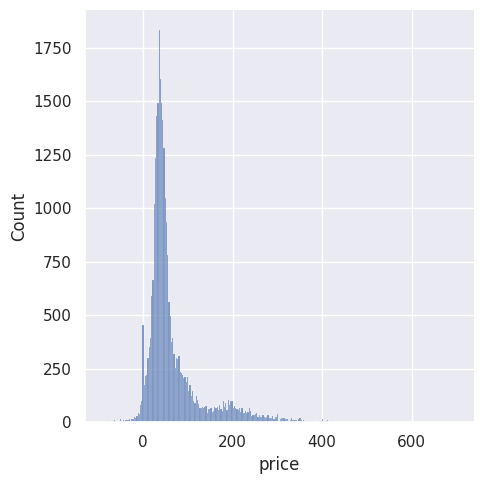

<Figure size 640x480 with 0 Axes>

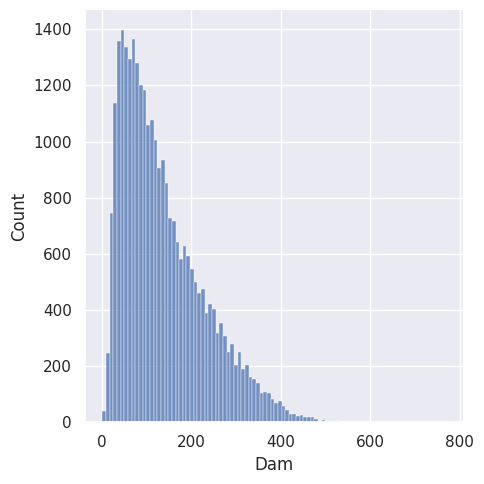

<Figure size 640x480 with 0 Axes>

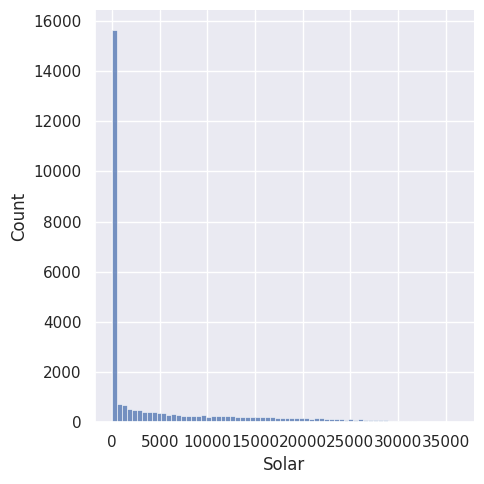

<Figure size 640x480 with 0 Axes>

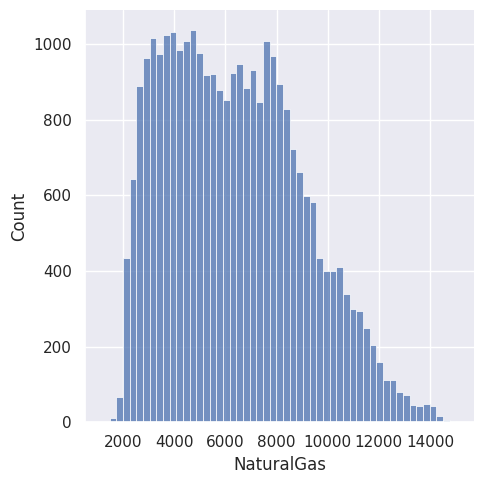

<Figure size 640x480 with 0 Axes>

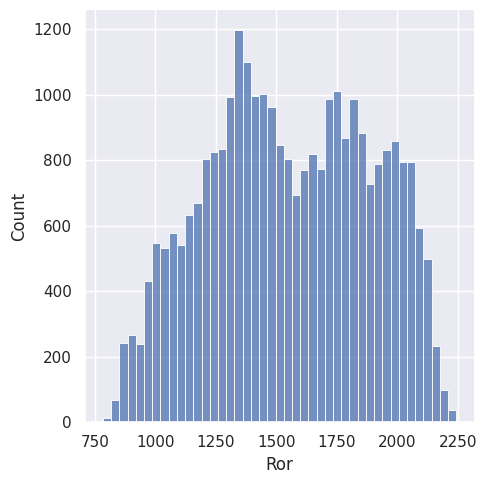

<Figure size 640x480 with 0 Axes>

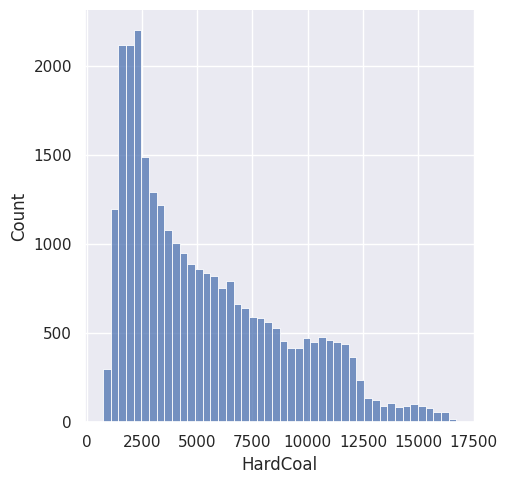

<Figure size 640x480 with 0 Axes>

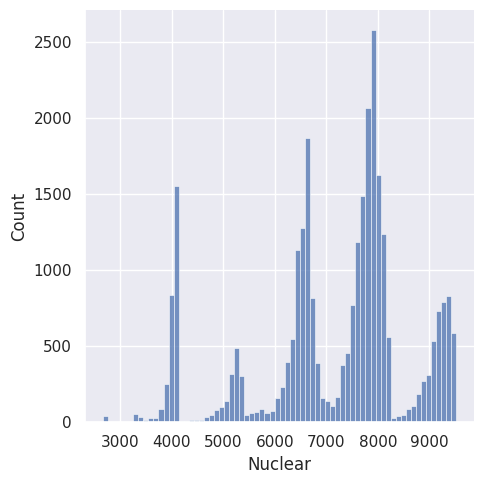

<Figure size 640x480 with 0 Axes>

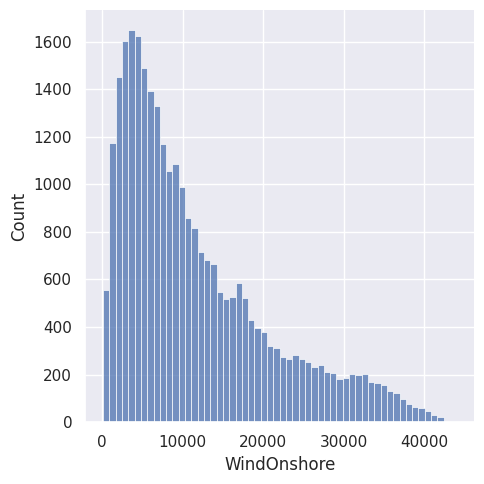

<Figure size 640x480 with 0 Axes>

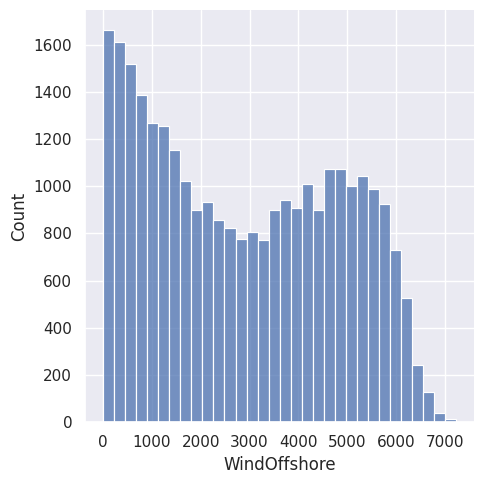

<Figure size 640x480 with 0 Axes>

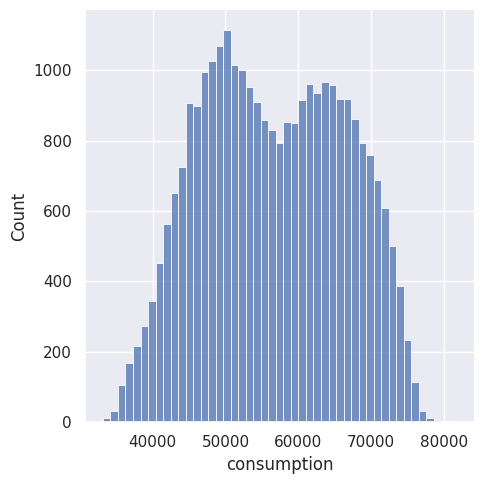

<Figure size 640x480 with 0 Axes>

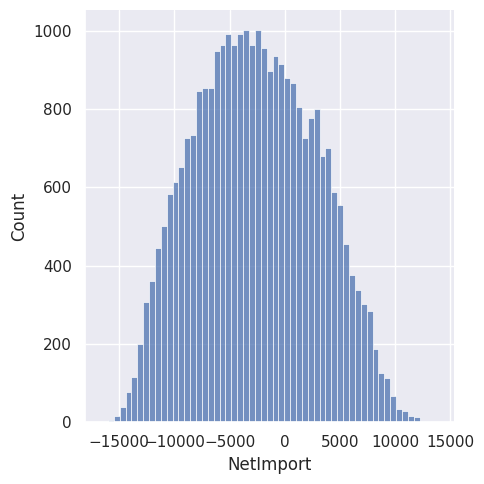

<Figure size 640x480 with 0 Axes>

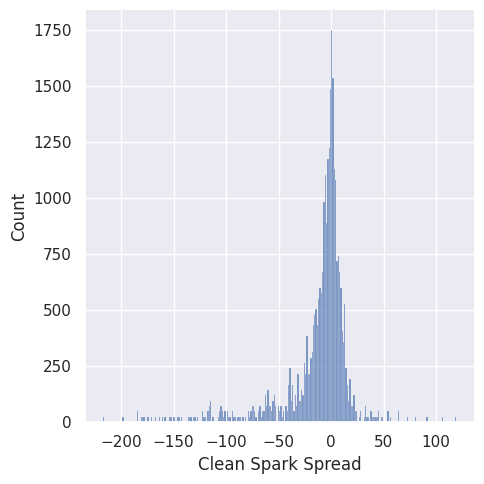

<Figure size 640x480 with 0 Axes>

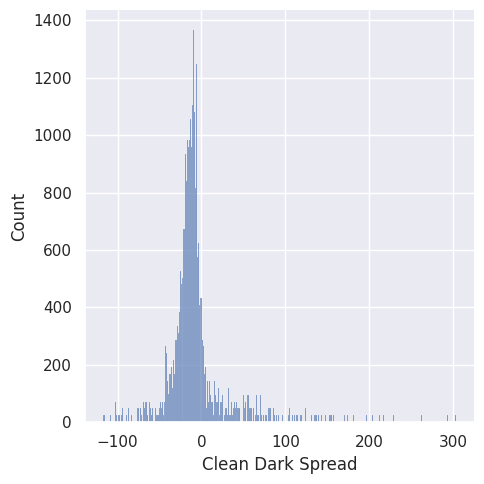

<Figure size 640x480 with 0 Axes>

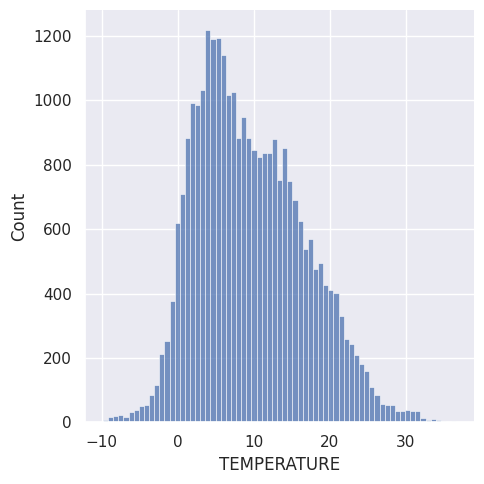

<Figure size 640x480 with 0 Axes>

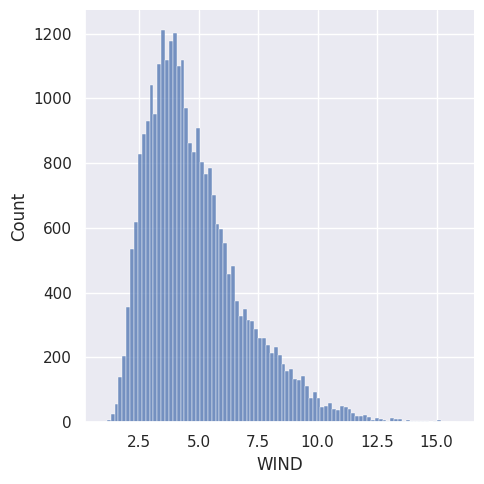

In [ ]:
for i in result_df.columns:
        fig = plt.figure()
        ax = sns.displot(x=result_df[i])

Obviously, features do not have a normal distribution so I can not use the z-score or standard deviation to detect outliers. I will use the IQR technique.

I plot the boxplot for each feature i.e I use the IQR. The points that lie beyond the whiskers are outliers.

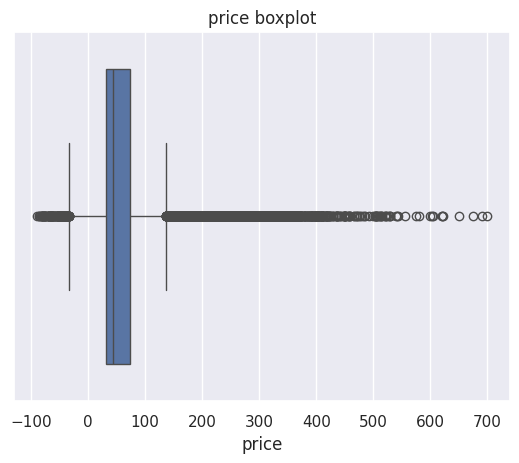

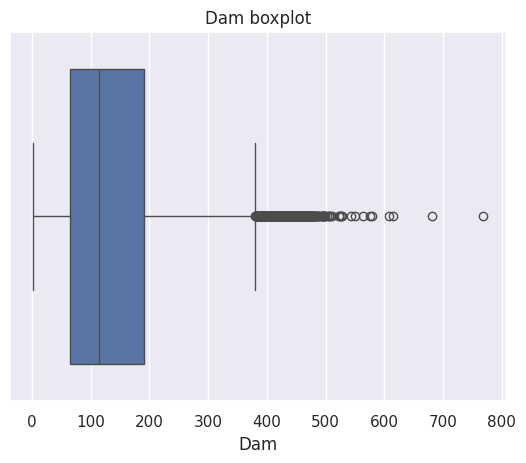

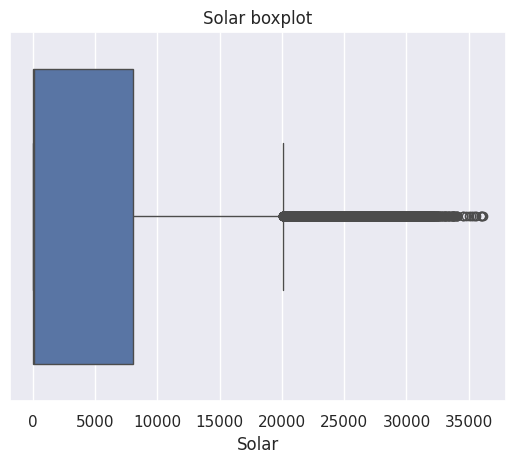

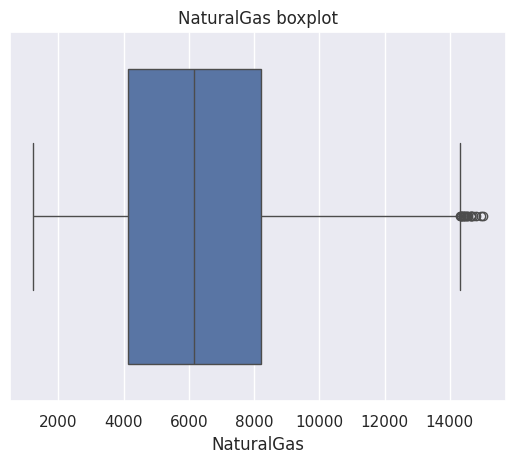

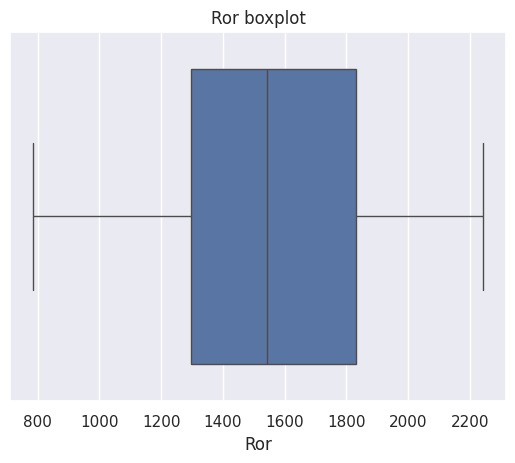

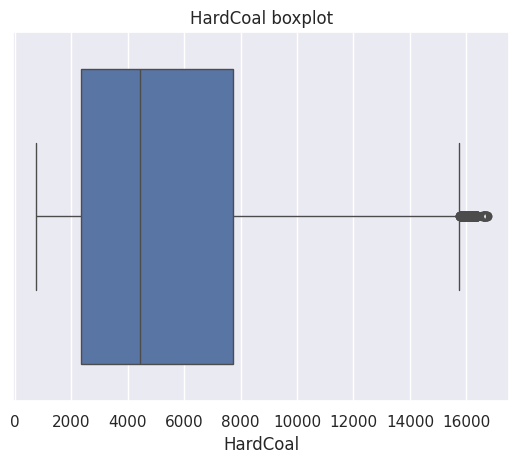

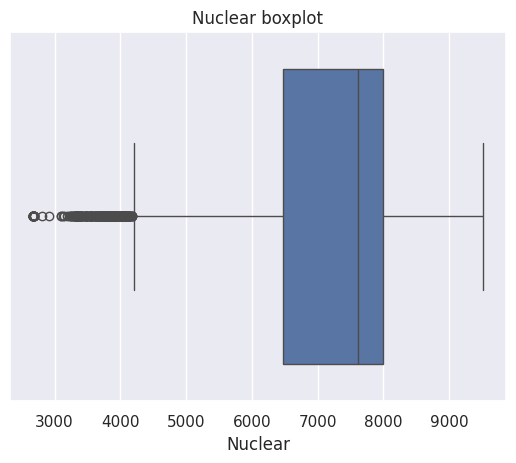

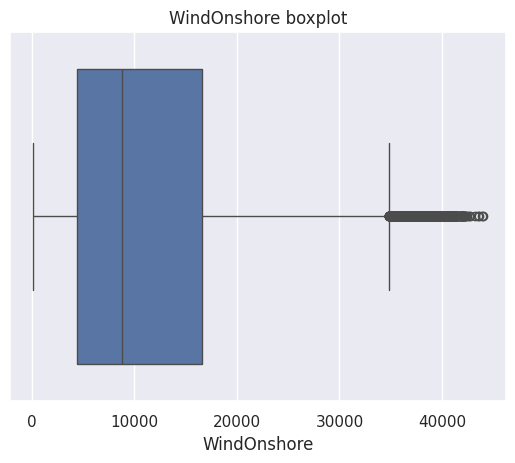

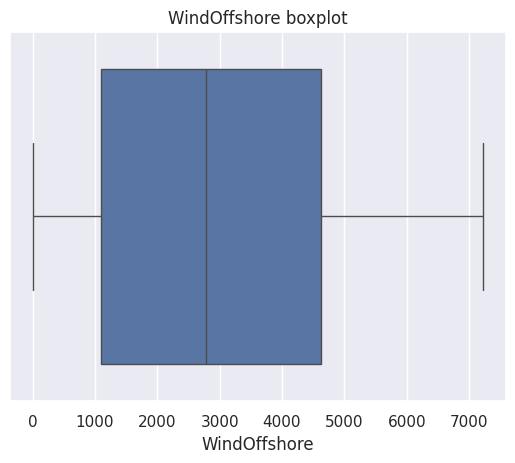

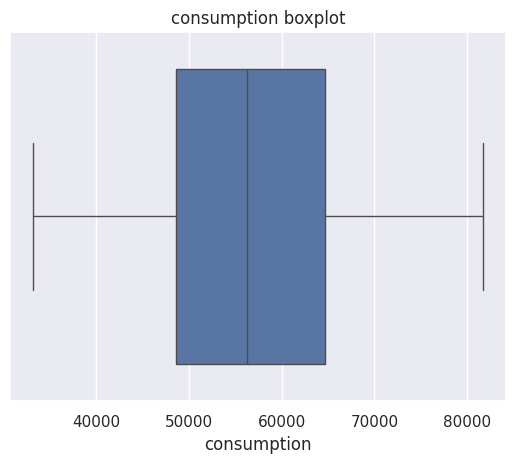

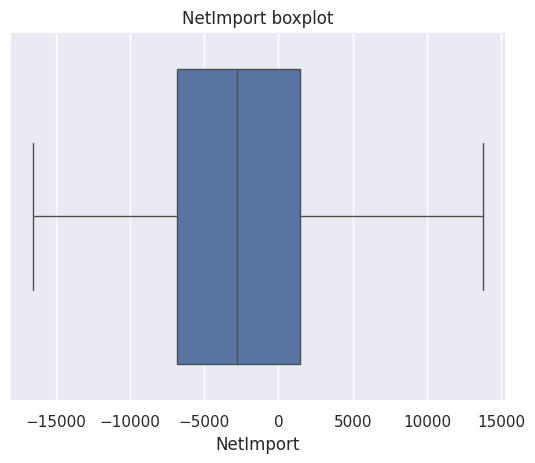

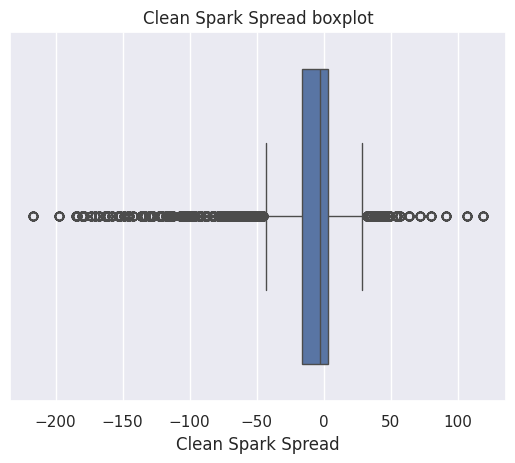

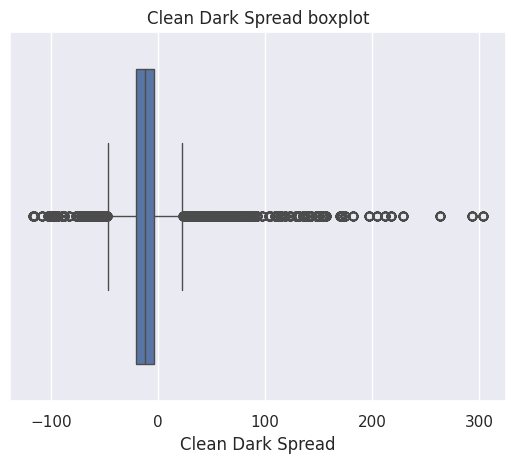

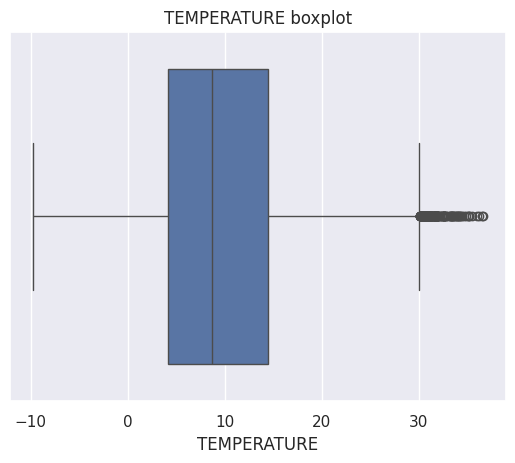

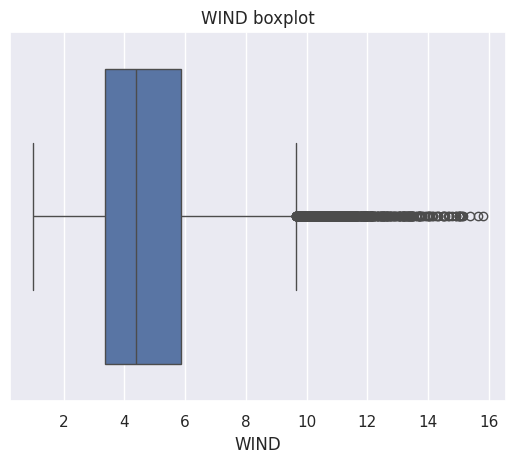

In [ ]:
for i in result_df.columns:
        fig = plt.figure()
        ax = sns.boxplot(x=result_df[i]).set(title=f'{i} boxplot')

The interquartile range works by dropping all points that are outside the range [q25 - 1.5*IQR, q75 + 1.5*IQR] as outliers. But removing outliers this way may not be the most optimal choice as we can see we have a wide distribution for certain features.

Let’s define a custom range that accommodates all data points that lie anywhere between 0.5 and 99.5 percentile of the dataset.
Rather than just deleting these outliers, I prefer to set the value to NaN and then fill the value by interpolation rather than forward fill to have a more realistic and smoother value.

In [ ]:
for column in result_df.columns:
    lower_limit, upper_limit = np.percentile(result_df[column],q=[0.5,99.5])
    result_df.loc[result_df[column] > upper_limit, column]=np.nan
    result_df.loc[result_df[column] < lower_limit, column]=np.nan

In [ ]:
result_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

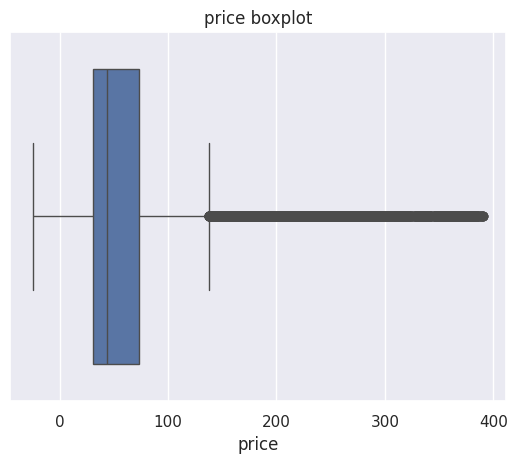

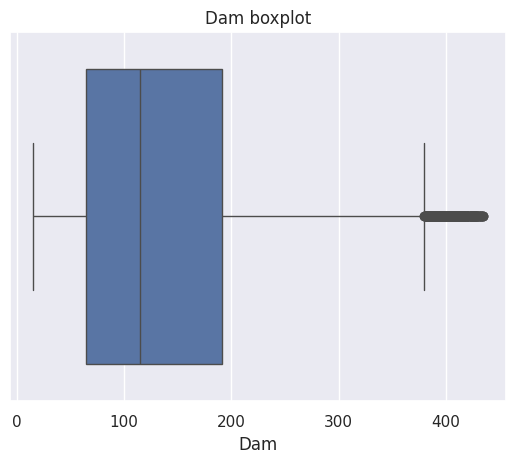

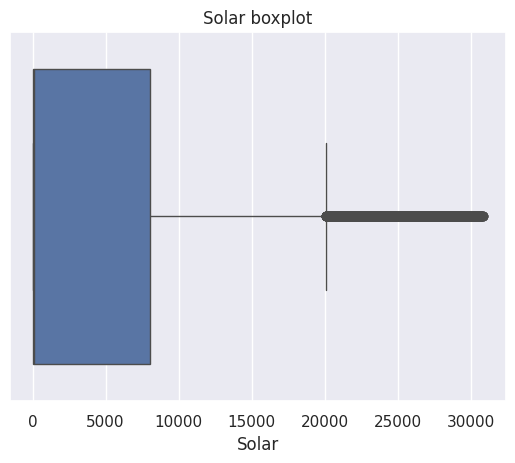

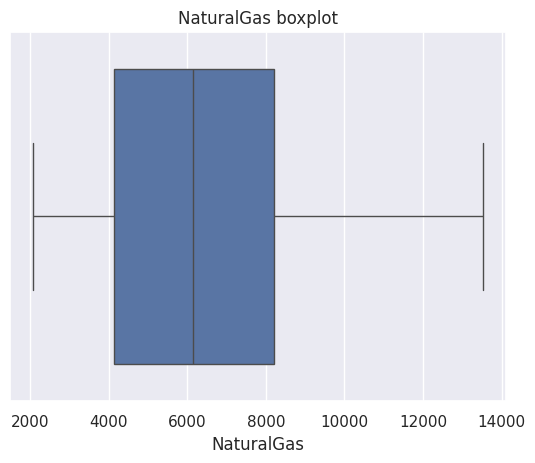

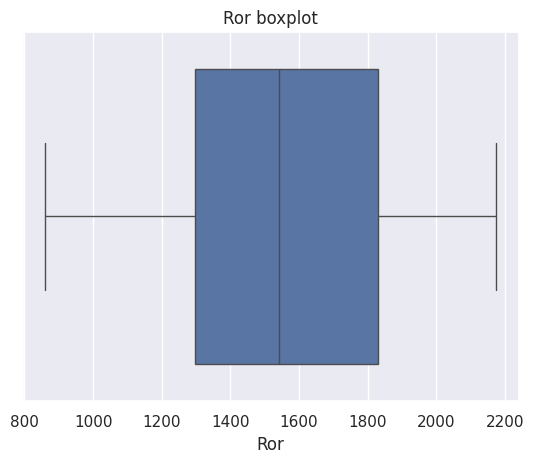

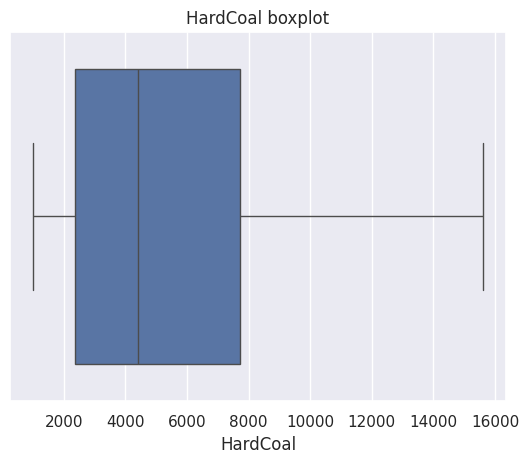

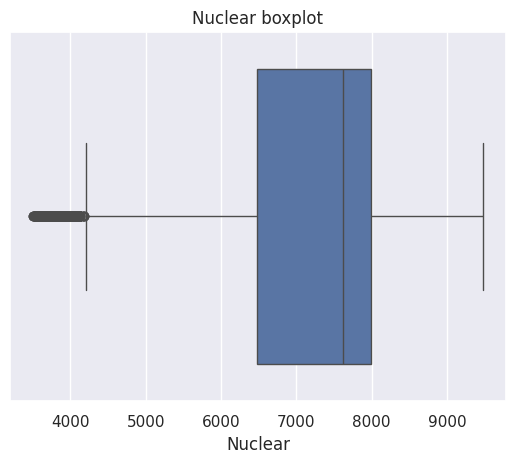

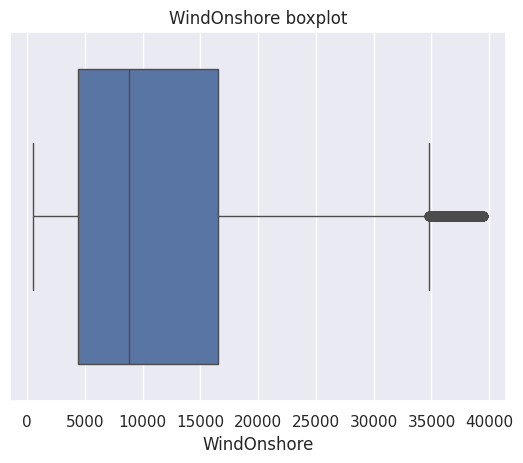

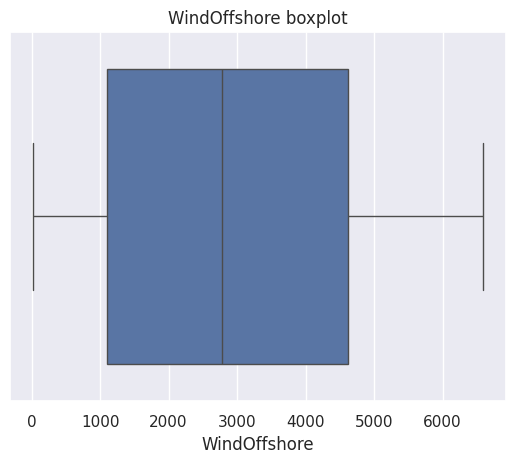

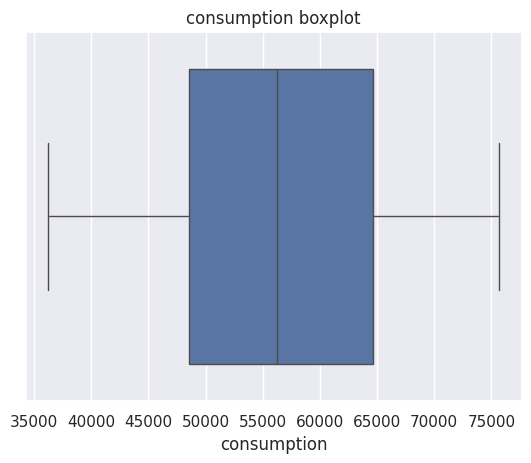

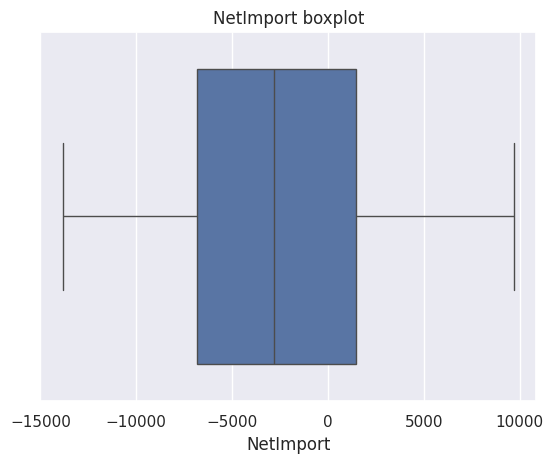

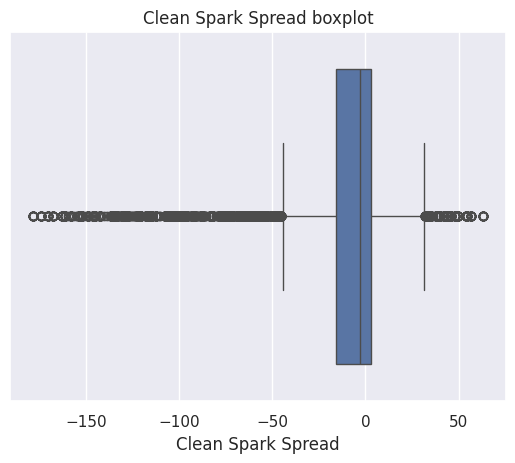

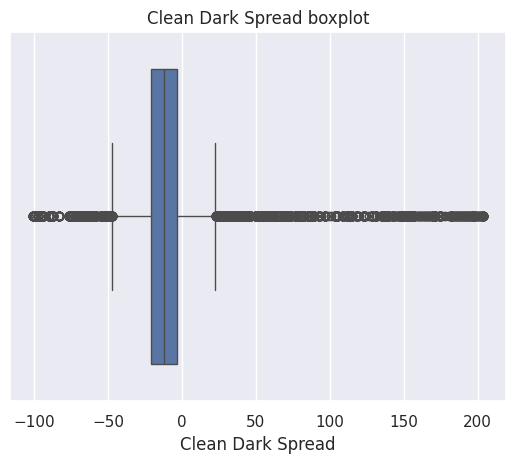

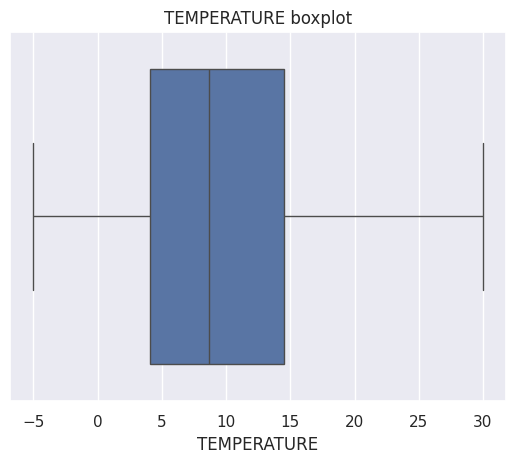

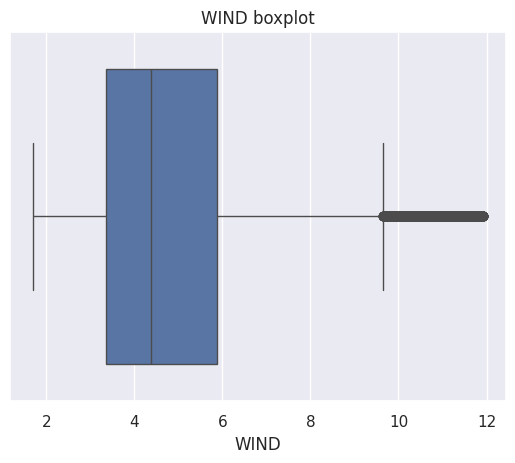

In [ ]:
for i in result_df.columns:
        fig = plt.figure()
        ax = sns.boxplot(x=result_df[i]).set(title=f'{i} boxplot')

Now that my data is cleaned, I'm ready to build models to predict the the day-ahead electricity prices for May and June 2022.

## II : Building Models

First, I'm going to see how features are correlated to see which feature impact most the price.

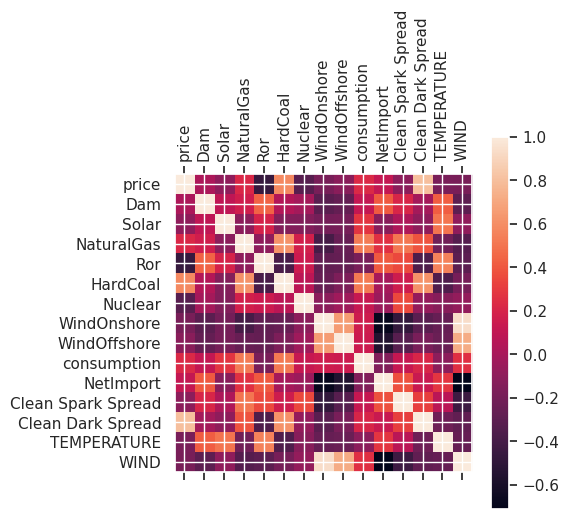

In [ ]:
plt.matshow(result_df.corr())
plt.xticks(np.arange(len(result_df.columns)), result_df.columns, rotation=90)
plt.yticks(np.arange(len(result_df.columns)), result_df.columns, rotation=0)
plt.colorbar()
plt.show()

We notice that the price is associated with Clean Dark Spread but it also correlates with Natural Gas and Hard Coal which makes sense. It is strongly inversely correlated with Ror and Nuclear.

###  a) Linear Regression Model

I use the regression model because it is the simplest one.
First, I prepare the data. That is, I prepare the feature (X) and target (y) datasets for the regression.
Then, I standardize X.
Finally, I split the data set into training and validation sets.

In [ ]:
X = result_df[["Dam", "Solar", "NaturalGas", "Ror", "HardCoal", "Nuclear", "WindOnshore", "WindOffshore", "consumption",
               "NetImport", "Clean Spark Spread", "Clean Dark Spread", "TEMPERATURE", "WIND"]].values
y = result_df[["price"]].values

# Standardization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset: 80% training set, 20% validation set
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

Then, I train my model.

Score:  0.8588376774262869
Weights:  [[  1.81797109 -18.62860552 -13.45018553  -4.20831509  -2.14800694
  -14.68196834 -15.24792344  -4.00983915  26.5148531   -5.50310617
  -23.4253199   51.48578125   3.6656454   -9.35472074]]


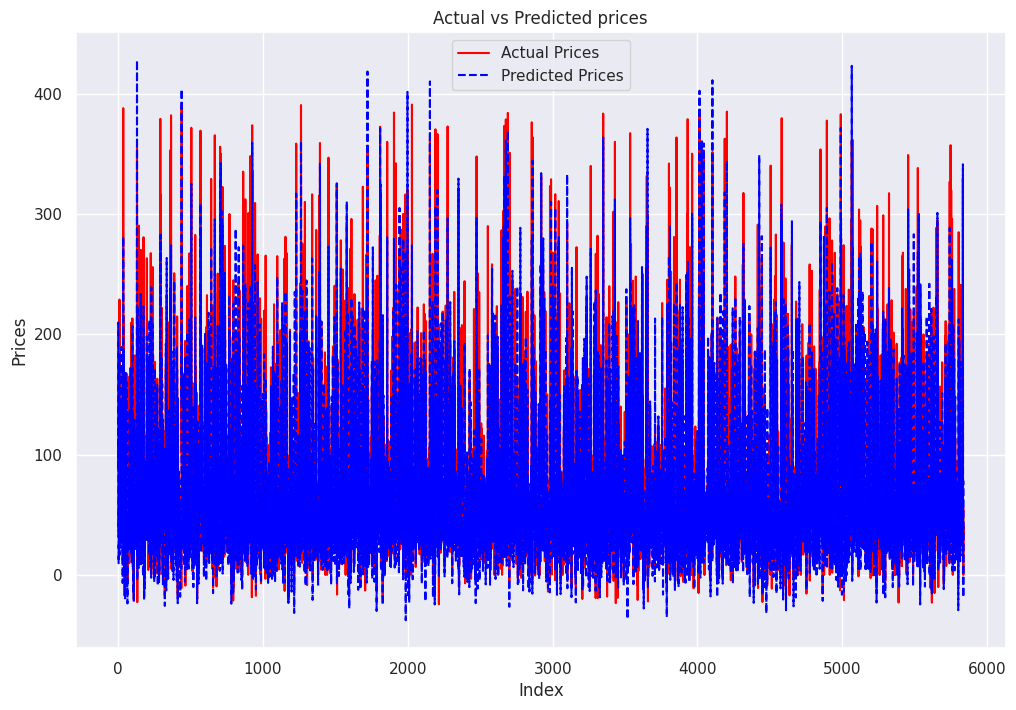

<ipython-input-30-921c48c18f32>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_temp.min(), y_temp.max()], [y_temp.min(), y_temp.max()], 'k--', lw=2,color='red')


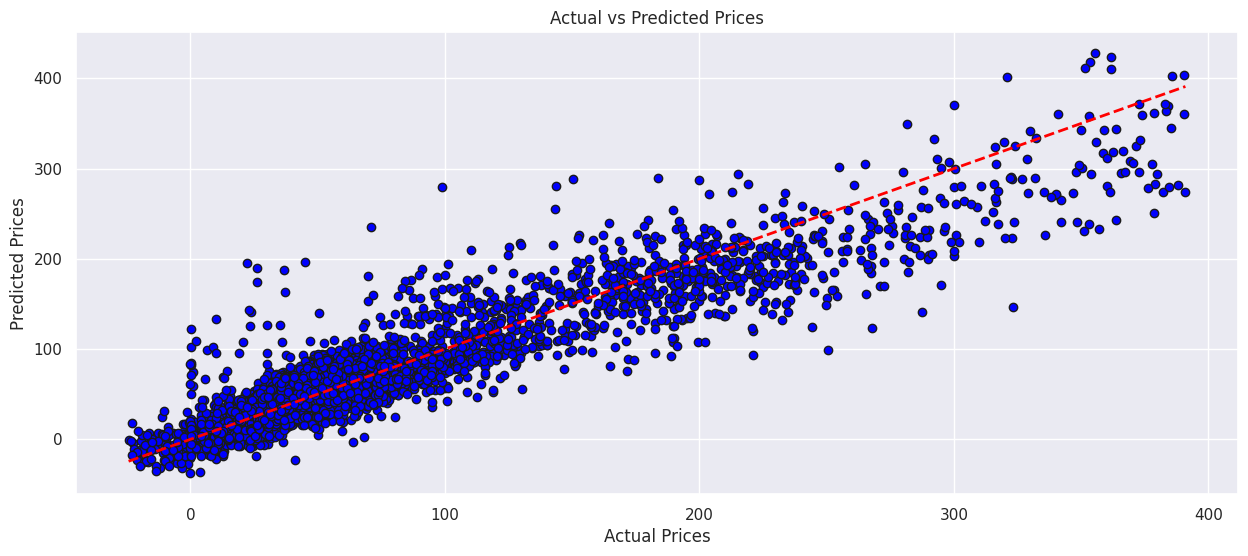

In [ ]:
lineReg = LinearRegression()
lineReg.fit(X_train, y_train)

# Evaluation of the model
score = lineReg.score(X_temp, y_temp)
print('Score: ', score)
print('Weights: ', lineReg.coef_)

# Predictions
y_pred = lineReg.predict(X_temp)

# Plot predictions vs actual prices
plt.figure(figsize=(12, 8))
plt.plot(y_temp, label='Actual Prices', color='red', linestyle='-')
plt.plot(y_pred, label='Predicted Prices', color='blue', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Prices')
plt.legend()
plt.title('Actual vs Predicted prices')
plt.show()

# Plot prediction vs actual prices (scatter plot)
plt.figure(figsize=(15, 6))
plt.scatter(y_temp, y_pred, color='blue', edgecolors='k')
plt.plot([y_temp.min(), y_temp.max()], [y_temp.min(), y_temp.max()], 'k--', lw=2,color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

In [ ]:
mse=mean_squared_error(y_temp, y_pred)
mae=mean_absolute_error(y_temp, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 621.3664985710267
Mean Absolute Error: 16.835517540006467


To see if my model is correct, I need to test if residuals follow a normal distribution.

If the residuals do not follow a normal distribution, it may indicate that the model does not adequately capture the variability of the data or that there are nonlinear or non-Gaussian structures in the data. In such cases, the model's predictions may not be reliable outside the range of the observed data.

In the context of linear regression, the model coefficients are interpreted as the average effects of each independent variable on the dependent variable, under the assumption that the residuals follow a normal distribution. If this assumption is violated, the interpretation of the coefficients may be incorrect.

Evaluating the normality of the residuals will help me compare different models and make appropriate transformations of the variables to improve the model fit such as feature selection.

Shape of y_temp: (5837, 1)
Shape of y_pred: (5837, 1)


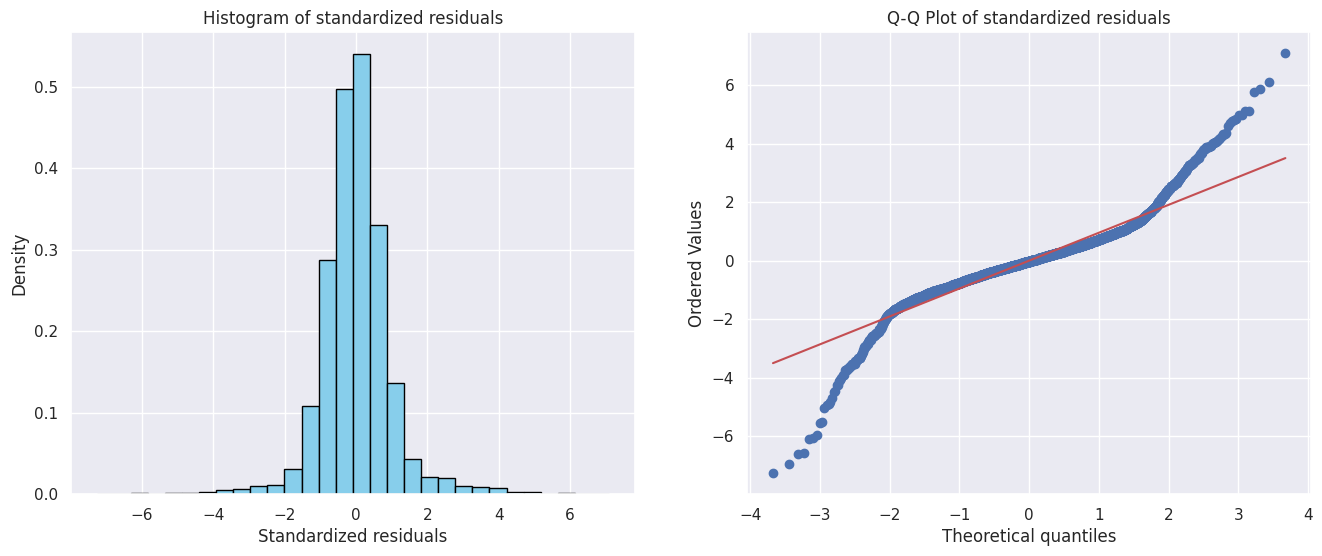

In [ ]:
print("Shape of y_temp:", y_temp.shape)
print("Shape of y_pred:", y_pred.shape)

if len(y_temp.shape) > 1 and y_temp.shape[1] == 1:
    y_temp = y_temp.squeeze()

if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
    y_pred = y_pred.squeeze()

residuals = y_temp - y_pred

std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(std_residuals, bins=30, color='skyblue', edgecolor='black', density=True)
ax[0].set_title('Histogram of standardized residuals')
ax[0].set_xlabel('Standardized residuals')
ax[0].set_ylabel('Density')

probplot(std_residuals, plot=ax[1], fit=True)
ax[1].set_title('Q-Q Plot of standardized residuals')

plt.show()

To test the normality of the residuals I do a Shapiro test where the null Hypothesis is that the residuals follow a normal distribution and the alternative hypothesis is that residuals do not follow a normal distribution.

In [ ]:
residuals = y_temp - y_pred

stat, p_value = shapiro(residuals)

print("Statistique de test Shapiro-Wilk:", stat)
print("P-value:", p_value)

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("residuals follow a normal distribution")
else:
    print("residuals do not follow a normal distribution")

Statistique de test Shapiro-Wilk: 0.9087074129155392
P-value: 1.8938038758857576e-50
residuals do not follow a normal distribution


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5837.
  res = hypotest_fun_out(*samples, **kwds)


There are several things to note:
- First, we can see that the R squared is 0.85 close to 1
- On the 2nd plot, the red dashed line represents a perfect prediction line where actual and predicted values would be identical. By looking at the plot, we can see that points do not cluster closely around the diagonal red dashed line they are scattered, indicating that the model's predictions are not that close to the true values
- I have high values for both MSE and MAE. A high MSE indicates bad agreement between predictions and actual values while a high MAE also signifies bad model performance. Both MSE and MAE are measures of prediction accuracy. As we have high values for both metrics, we can suggest that our model performs poorly.
- The residuals do not follow a normal distribution so the results of the model might not be good.

All in all, it's the simplest model so it is expected that it does not perform really well. To improve my model, I'm going to add a ridge penalty.

### b) Ridge Regression Model

I use RepeatedKFold to perform cross-validation with 20 folds and 4 repeats.

RidgeCV is used to find the best alpha value from a logarithmic grid of values.
RidgeCV_model.alpha_ provides the best alpha value found.
Then I train the model with the best alpha found.

Score:  0.8588342984263143
Best Alpha:  1.0
Weights:  [[  1.81974444 -18.60540861 -13.43908783  -4.21147138  -2.12916208
  -14.67538477 -15.21639042  -4.00171021  26.48886926  -5.48400291
  -23.4225573   51.47997407   3.663481    -9.36101618]]


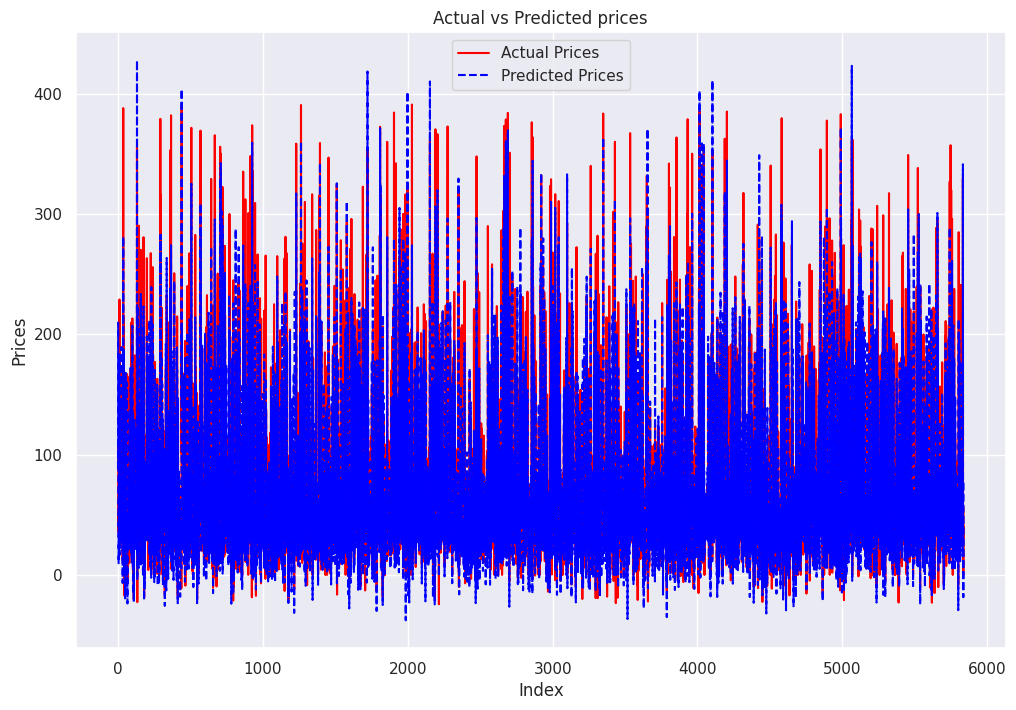

<ipython-input-34-b87285760221>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_temp.min(), y_temp.max()], [y_temp.min(), y_temp.max()], 'k--', lw=2, color='red')


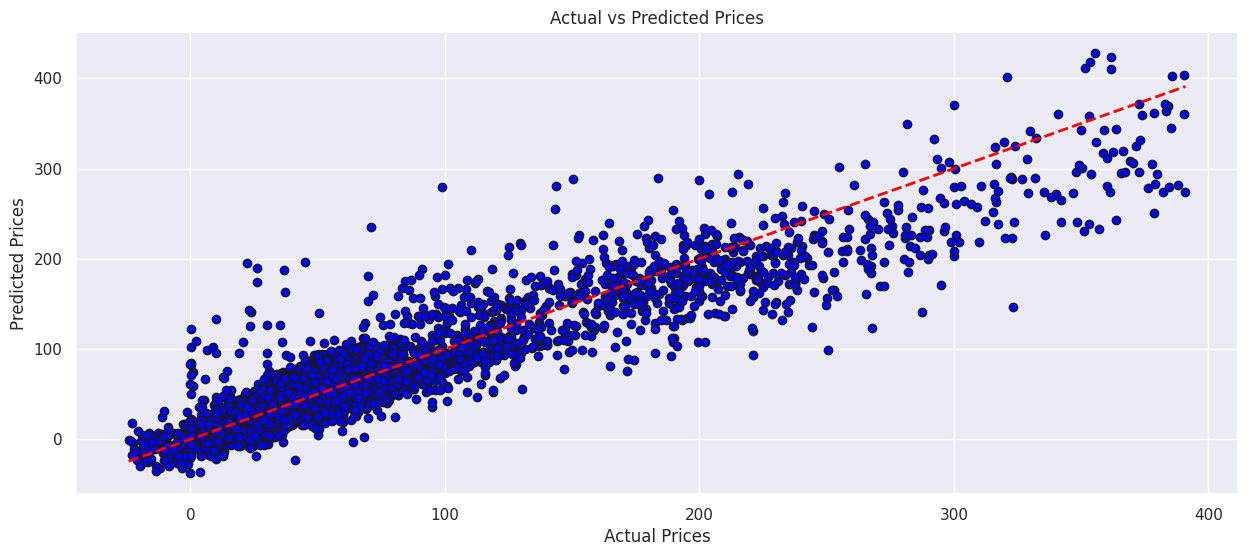

Mean Squared Error: 621.3813722097098
Mean Absolute Error: 16.835401469984525


In [ ]:
cv = RepeatedKFold(n_splits=20, n_repeats=4, random_state=1)

alphas = np.logspace(-6, 6, 13)
RidgeCV_model = RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_squared_error')
RidgeCV_model.fit(X_train, y_train)

RidgeReg = Ridge(alpha=RidgeCV_model.alpha_)
RidgeReg.fit(X_train, y_train)

score = RidgeReg.score(X_temp, y_temp)
print('Score: ', score)
print('Best Alpha: ', RidgeCV_model.alpha_)
print('Weights: ', RidgeReg.coef_)

y_pred = RidgeReg.predict(X_temp)

plt.figure(figsize=(12, 8))
plt.plot(y_temp, label='Actual Prices', color='red', linestyle='-')
plt.plot(y_pred, label='Predicted Prices', color='blue', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Prices')
plt.legend()
plt.title('Actual vs Predicted prices')
plt.show()

plt.figure(figsize=(15, 6))
plt.scatter(y_temp, y_pred, color='blue', edgecolors='k')
plt.plot([y_temp.min(), y_temp.max()], [y_temp.min(), y_temp.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

mse = mean_squared_error(y_temp, y_pred)
mae = mean_absolute_error(y_temp, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

We can see that adding a ridge regression does not improve things as expected as MSE and MAE are still quite high.

I'm going to perform feature selection to maybe improve things.

### Feature Selection

I will calculate the p-value for each future in my data set, then based on this p-value and the significance level I will choose which feature to consider or not. There are different methods or algorithms to select features based on p-values. The most common in the linear regression context are backward and forward elimination. I will use the stepwise selection which combines backward and forward selection by adding and removing features in each step. It is said to yield better results than forward or backward selection.

In [ ]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.6}')

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.6}')
        if not changed:
            break
    return included

In [ ]:
X = result_df[["Dam", "Solar", "NaturalGas", "Ror", "HardCoal", "Nuclear", "WindOnshore", "WindOffshore", "consumption",
               "NetImport", "Clean Spark Spread", "Clean Dark Spread", "TEMPERATURE", "WIND"]]
y = result_df["price"]

result = stepwise_selection(X, y)
print('Selected features:', result)

Add  Nuclear with p-value 0.0
Add  TEMPERATURE with p-value 0.0
Add  WIND with p-value 0.0
Add  HardCoal with p-value 0.0
Add  Clean Dark Spread with p-value 0.0
Add  Clean Spark Spread with p-value 0.0
Add  consumption with p-value 0.0
Drop TEMPERATURE with p-value 0.0715038
Add  Solar with p-value 0.0
Drop HardCoal with p-value 0.860254
Add  NaturalGas with p-value 7.43001e-274
Add  WindOnshore with p-value 3.86449e-77
Add  Ror with p-value 6.14115e-31
Add  TEMPERATURE with p-value 1.27301e-68
Add  WindOffshore with p-value 3.09869e-33
Add  NetImport with p-value 5.441e-43
Add  Dam with p-value 3.59259e-21
Add  HardCoal with p-value 2.89506e-11
Selected features: ['Nuclear', 'WIND', 'Clean Dark Spread', 'Clean Spark Spread', 'consumption', 'Solar', 'NaturalGas', 'WindOnshore', 'Ror', 'TEMPERATURE', 'WindOffshore', 'NetImport', 'Dam', 'HardCoal']


We see that the stepwise selection do not restrict the number of features selected. There might be several reasons for that:

- I assumed a linear relationship between the features and the target variable, which may not be the case.
- The reliance on p-values for feature elimination is problematic as the dataset is really important and p-values can sometimes be misleading.

### c) Random Forest

I'm going to use another model for feature selection. I decided to use random forest because:

- Random Forest provides a measure of feature importance by evaluating how much each feature decreases the variance in a tree. Features that are used more often in the decision trees and at higher levels (nearer to the root) typically indicate higher importance.

- Random forests consider random subsets of features for each tree so they can handle multicollinearity better than some other feature selection methods.

- Random Forests are less prone to overfitting compared to individual decision trees, making the feature importance scores more reliable.

- Random forests do not assume that features are independent, which is an advantage over linear models that assume feature independence when estimating coefficients.

Explanation of the algorithm:

- Train the Model
- Compute Feature Importances
- Rank Features based on their importance score
- Select Important Features based on a predefined threshold or by selecting the top N features

               feature  importance
11   Clean Dark Spread    0.689238
10  Clean Spark Spread    0.087098
4             HardCoal    0.072142
2           NaturalGas    0.037159
5              Nuclear    0.024048
3                  Ror    0.019140
9            NetImport    0.017899
13                WIND    0.014262
8          consumption    0.013638
12         TEMPERATURE    0.006947
0                  Dam    0.005398
6          WindOnshore    0.004945
7         WindOffshore    0.004084
1                Solar    0.004002


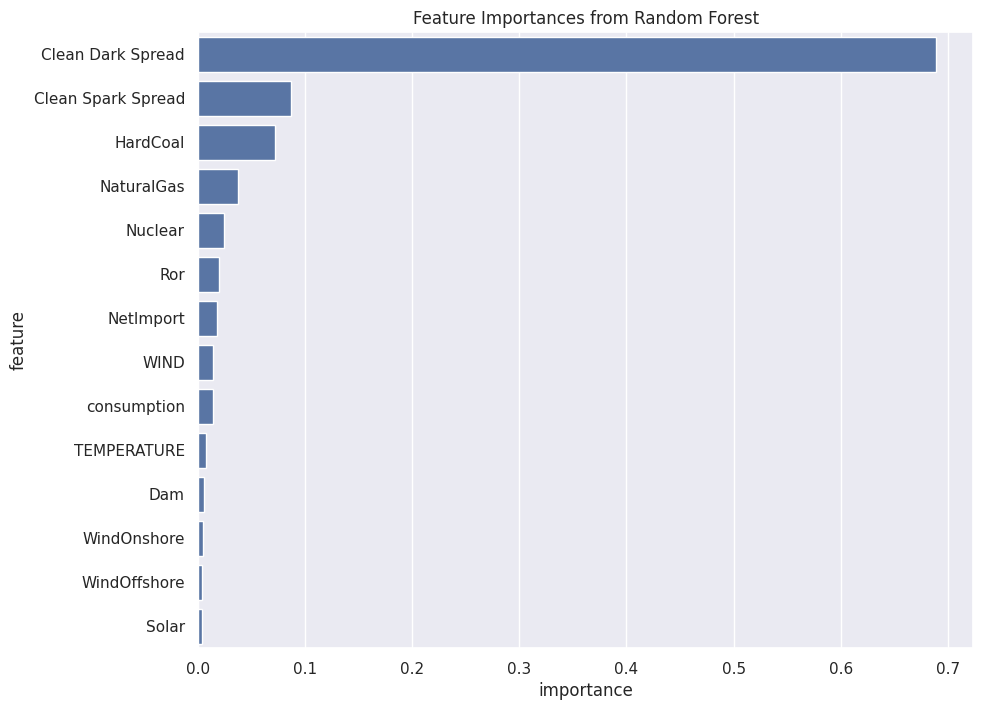

In [ ]:
X = result_df[["Dam", "Solar", "NaturalGas", "Ror", "HardCoal", "Nuclear", "WindOnshore", "WindOffshore", "consumption",
               "NetImport", "Clean Spark Spread", "Clean Dark Spread", "TEMPERATURE", "WIND"]]
y = result_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
feature_importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})

feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
print(feature_importances_df)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances from Random Forest')
plt.show()

Selected features: ['Clean Dark Spread', 'Clean Spark Spread', 'HardCoal', 'NaturalGas', 'Nuclear', 'Ror', 'NetImport', 'WIND', 'consumption']
Model performance on test set:
R-squared: 0.978
MSE: 94.660
MAE: 5.456


<ipython-input-38-3da35b71472a>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4,color='red')


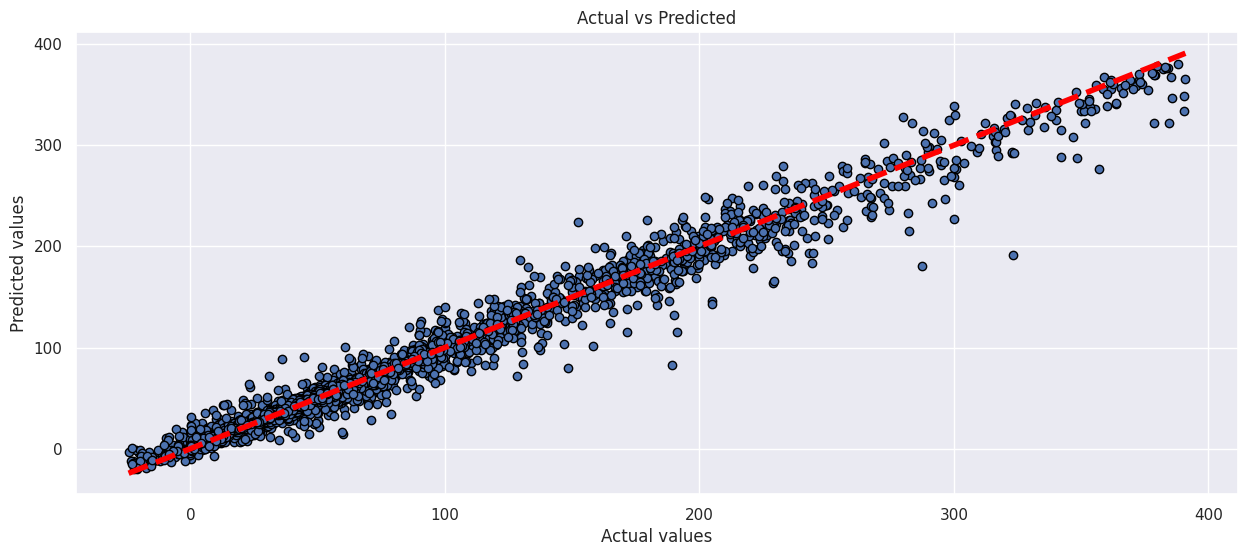

In [ ]:
threshold = 0.01
important_features = feature_importances_df[feature_importances_df['importance'] > threshold]['feature']

print("Selected features:", important_features.tolist())

X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

rf_important = RandomForestRegressor(n_estimators=100, random_state=42)
rf_important.fit(X_train_important, y_train)

y_pred = rf_important.predict(X_test_important)

r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model performance on test set:\nR-squared: {r_squared:.3f}\nMSE: {mse:.3f}\nMAE: {mae:.3f}")

plt.figure(figsize=(15, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4,color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
print(f"Model performance on test set:\nR-squared: {r_squared:.3f}\nMSE: {mse:.3f}\nMAE: {mae:.3f}")

Model performance on test set:
R-squared: 0.978
MSE: 94.660
MAE: 5.456


We have a dramatic improvement in the coefficient of determination, mean squared error and mean absolute error compared to linear regression and ridge regression. For now, random forest is the best model.

### d) Linear Regression with selected features

I select only the important features and re run a linear regression with the selected features.

Model performance on test set :
R-squared: 0.844
MSE: 687.890
MAE: 17.552


<ipython-input-40-58fb7a85bc37>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4,color='red')


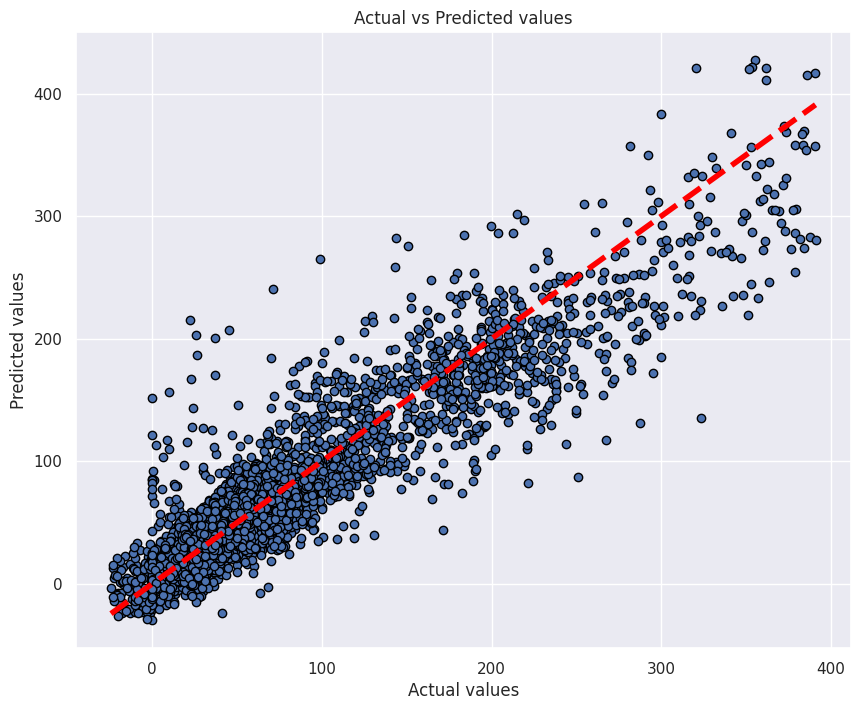

In [ ]:
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

lr = LinearRegression()
lr.fit(X_train_important, y_train)

y_pred = lr.predict(X_test_important)

r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model performance on test set :\nR-squared: {r_squared:.3f}\nMSE: {mse:.3f}\nMAE: {mae:.3f}")

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4,color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.show()

In [ ]:
print(f"Model performance on test set :\nR-squared: {r_squared:.3f}\nMSE: {mse:.3f}\nMAE: {mae:.3f}")

Model performance on test set :
R-squared: 0.844
MSE: 687.890
MAE: 17.552


We can see that the results for the different metrics are worst than before feature selection. So what I did, did not have a positive impact on my model. I'm going to build another model called ARIMA model to try to predict prices.

### e) Neural Newtorks

I define a function 'multivariate_data' to prepare data for my Neural Net model. It transforms my different time series in a compatible format for the models. It will create sequences of historical data and the target to train the model.

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

Choosing training, testing and validation indices

In [ ]:
train_end_idx = int(len(result_df) * 0.77)
cv_end_idx = int(len(result_df) * 0.88)
test_end_idx = len(result_df)

Preparing the data

In [ ]:
X = result_df[result_df.columns.drop('price')].values
y = result_df['price'].values

y = y.reshape(-1, 1)

I normalize data to help accelerate convergence, have better performance and to have a uniforme scale

In [ ]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

I transform the validation and test sets

In [ ]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

I use PCA to reduce the dimensionality of my training dataset

In [ ]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

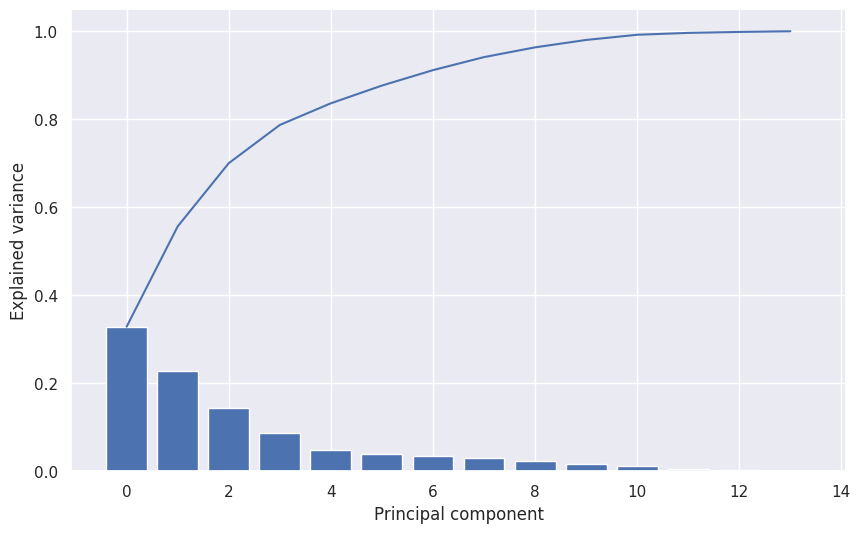

In [ ]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

I only keep the components that explain 80% of the total variance

In [ ]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)
X_pca.shape

(29183, 5)

I concatenate the principal features and the value I want to predict which is the price.
I use the last 24 hours of data to predict the future value.
I set future_target as 0 in order to predict the actual value and not the value of the next hour for example.

In [ ]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

Then I split my data set into training, validation and test set. It will create subset of timeseries of 24 hours in order to predict the actual value. I initialize step=1 and single_step to True so that each sequence will be created with a time step of 1 hour (which is the case of my dataset) and to predict only for one point (1 hour).

In [ ]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

The below code prepares train and validation data to be used by converting them into tf Data set objects. This approach is efficient and allows for easy batch processing, data shuffling, and caching.
Tensor slices splits X and y into individual samples. The function cache() caches the elements of the dataset in memory to speed up subsequent operations while batch divides the dataset into batches of size batch_size and prefetch(1) prepares 1 batch in advance to ensure a continuous flow of data to the model during training.

I use this approach because it optimizes training by preparing batches of data in advance and minimizing wait times, reduces memory consumption and simplifies data handling during training and validation.

In [ ]:
batch_size = 32
buffer_size = 1000

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [ ]:
input_shape = X_train.shape[-2:] # extract last 2 dimensions of X_train
loss = tf.keras.losses.MeanSquaredError() # loss function for regression tasks
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10)) # adjust learning rate during training
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10) # prevent overfitting

In [ ]:
y_test = y_test.reshape(-1, 1) # reshape to a 2D array with single column
y_test_inv = scaler_y.inverse_transform(y_test) # convert normalized values to their normal scale used for interpretation

I define a function to compare validation and training RMSE and loss function

In [ ]:
def plot_rmse_and_loss(history):

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

#### 1) LSTM model

In [ ]:
model = Sequential([
    LSTM(100, input_shape=input_shape, return_sequences=True),
    Flatten(),
    Dense(200, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.keras', monitor='val_loss', save_best_only=True) #save model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, amsgrad=True)

model.compile(loss=loss,optimizer=optimizer,metrics=metric)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
result = model.fit(train, epochs=100,validation_data=validation,callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0141 - root_mean_squared_error: 0.1028 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1363
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1325
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.7988e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.1542e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.1939e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.7637e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 7/100
702/702 ━━━━━━━━━

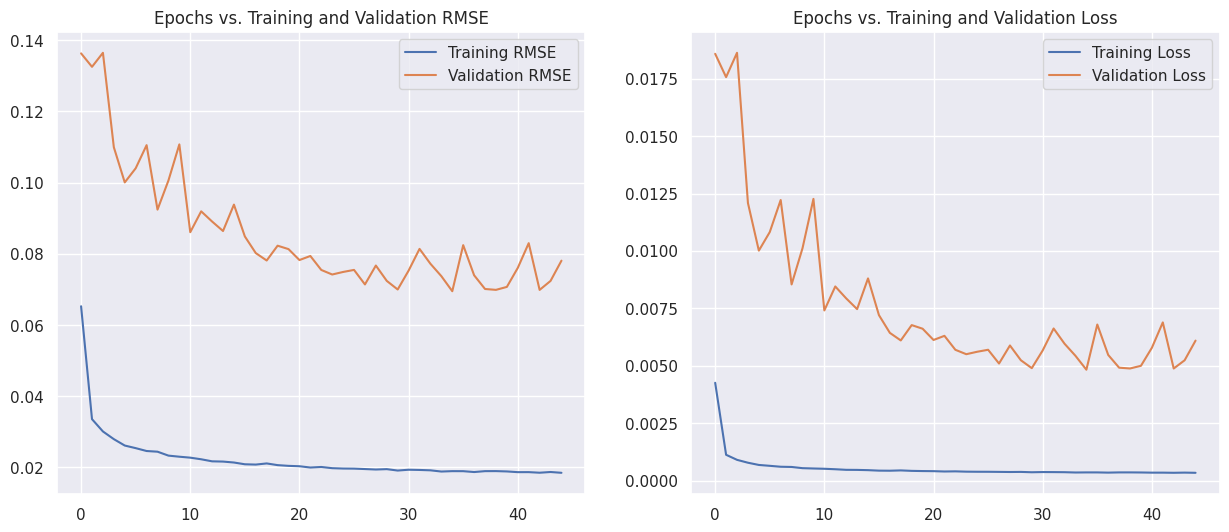

In [ ]:
plot_rmse_and_loss(result)

In [ ]:
loaded_model=load_model('my_model.keras')

forecast = loaded_model.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

mse_lstm = mean_squared_error(y_test_inv,lstm_forecast)
mae_lstm = mean_absolute_error(y_test_inv, lstm_forecast)

print("Mean Squared Error:", mse_lstm)
print("Mean Absolute Error:", mae_lstm)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean Squared Error: 549.7637590665466
Mean Absolute Error: 17.425245548643606


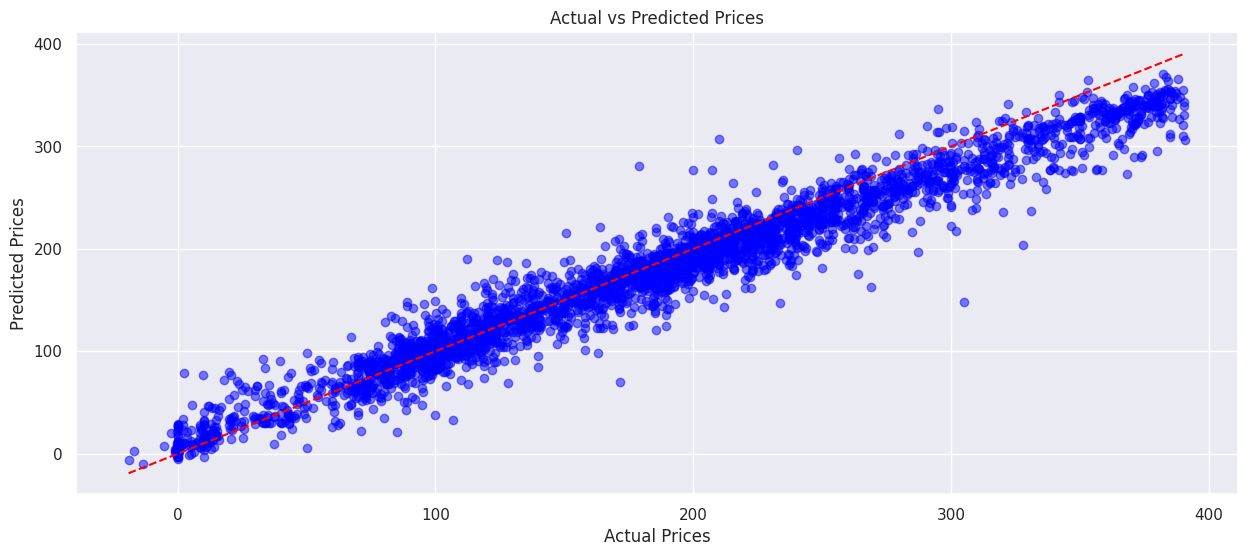

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(y_test_inv, lstm_forecast, color='blue', alpha=0.5)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], color='red', linestyle='--')
plt.show()

We can see that the LSTM model is better than Linear and Ridge Regression but worst than Random Forest.

#### 2) XGBoost Model

I reshape the arrays to combine the dimension of the time steps and features in a single dimension

In [ ]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

I choose to model a XGBoost model due to several reasons:

- XGBoost is known for its high performance and efficiency.
- XGBoost incorporates regularization techniques such as L1 and L2 regularization, which help prevent overfitting and improve generalization performance.
- XGBoost is based on gradient boosting, which allows XGBoost to capture complex relationships between features and the target variable, making it effective for regression tasks like mine.
- XGBoost is robust to noisy data and missing values. It can handle missing values internally and is less prone to overfitting compared to some other machine learning algorithms.

In [ ]:
param = {'eta': 0.01, 'max_depth': 200,
         'subsample': 1.0, 'colsample_bytree': 0.95,
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse',
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

# Creating DMatrix
dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=5)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:19:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:19:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.09074	eval-rmse:0.48920
[1]	train-rmse:0.08990	eval-rmse:0.48691
[2]	train-rmse:0.08907	eval-rmse:0.48473
[3]	train-rmse:0.08825	eval-rmse:0.48249
[4]	train-rmse:0.08744	eval-rmse:0.48036
[5]	train-rmse:0.08664	eval-rmse:0.47816
[6]	train-rmse:0.08584	eval-rmse:0.47608
[7]	train-rmse:0.08506	eval-rmse:0.47393
[8]	train-rmse:0.08428	eval-rmse:0.47189
[9]	train-rmse:0.08351	eval-rmse:0.46979
[10]	train-rmse:0.08275	eval-rmse:0.46779
[11]	train-rmse:0.08200	eval-rmse:0.46574
[12]	train-rmse:0.08126	eval-rmse:0.46379
[13]	train-rmse:0.08052	eval-rmse:0.46178
[14]	train-rmse:0.07979	eval-rmse:0.45986
[15]	train-rmse:0.07907	eval-rmse:0.45789
[16]	train-rmse:0.07835	eval-rmse:0.45603
[17]	train-rmse:0.07765	eval-rmse:0.45416
[18]	train-rmse:0.07695	eval-rmse:0.45225
[19]	train-rmse:0.07626	eval-rmse:0.45037
[20]	train-rmse:0.07558	eval-rmse:0.44857
[21]	train-rmse:0.07490	eval-rmse:0.44673
[22]	train-rmse:0.07423	eval-rmse:0.44496
[23]	train-rmse:0.07357	eval-rmse:0.44315
[2

In [ ]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

mse_xgb = mean_squared_error(y_test_inv, xgb_forecast_inv)
mae_xgb = mean_absolute_error(y_test_inv, xgb_forecast_inv)

print("Mean Squared Error:", mse_xgb)
print("Mean Absolute Error:", mae_xgb)

Mean Squared Error: 16215.319029845505
Mean Absolute Error: 99.75409707987974


The XGBoost model is the worst of the model I used by far.

## III : Making Predictions with the best model

I use the Random Forest model because it is the one with the lowest mse and mae

In [ ]:
production_test=production.reindex(net_imports.index)
costs_test=costs.reindex(net_imports.index)
consumption_test=consumption.reindex(net_imports.index)
weather_test=weather.reindex(net_imports.index)

In [ ]:
df_test=pd.concat([production_test,consumption_test,net_imports,costs_test,weather_test],axis=1)
df_test

,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore,consumption,NetImport,Clean Spark Spread,Clean Dark Spread,TEMPERATURE,WIND
Date,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,44.75,0.00,2882.50,1739.00,1711.00,5853.75,28660.25,2917.50,44877.75,-14676.00,NaN,NaN,8.19,8.76
2018-01-01 01:00:00+00:00,46.75,0.00,2936.75,1629.50,1609.25,4754.00,30105.50,2999.25,43816.50,-15591.00,NaN,NaN,7.85,8.77
2018-01-01 02:00:00+00:00,48.75,0.00,2903.50,1623.25,1683.25,4591.00,30772.75,3096.00,42820.00,-15995.00,NaN,NaN,7.54,8.07
2018-01-01 03:00:00+00:00,45.00,0.00,2886.00,1613.25,1679.50,4888.75,31641.50,3136.75,42051.75,-16235.00,NaN,NaN,7.29,8.93
2018-01-01 04:00:00+00:00,46.25,0.00,2898.50,1607.75,1677.50,4696.50,31529.00,3212.00,42061.50,-15445.00,NaN,NaN,6.93,9.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-29 19:00:00+00:00,411.50,4984.50,10228.50,1602.00,6982.25,3947.00,4062.25,2107.25,62430.75,3233.50,NaN,NaN,25.57,3.94
2022-06-29 20:00:00+00:00,345.25,1629.00,10119.25,1587.00,6977.75,3946.00,4227.25,2619.00,59611.25,4193.75,NaN,NaN,25.14,3.78
2022-06-29 21:00:00+00:00,343.00,132.75,9233.50,1611.50,7162.75,3950.75,5153.25,2803.50,57529.50,3327.25,NaN,NaN,23.82,3.64


In [ ]:
df_test=df_test.ffill()
df_test=df_test.loc['2022-05-01':]
df_test

,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore,consumption,NetImport,Clean Spark Spread,Clean Dark Spread,TEMPERATURE,WIND
Date,,,,,,,,,,,,,,
2022-05-01 00:00:00+00:00,44.75,0.00,3812.50,1146.25,5513.25,3961.50,3786.75,92.00,40505.50,1974.75,-37.98,28.27,8.56,2.50
2022-05-01 01:00:00+00:00,59.50,0.00,3866.75,1173.50,5243.50,3962.00,3386.25,76.75,38717.00,1393.00,-37.98,28.27,7.29,2.27
2022-05-01 02:00:00+00:00,86.00,0.00,3753.50,1194.00,5150.50,3963.75,3038.00,57.75,37616.50,689.25,-37.98,28.27,7.36,2.04
2022-05-01 03:00:00+00:00,43.25,0.00,3783.00,1192.25,5136.00,3964.50,2741.25,50.50,37067.00,664.50,-37.98,28.27,6.77,1.66
2022-05-01 04:00:00+00:00,42.00,0.00,3711.25,1197.50,5143.50,3964.75,2553.00,26.50,37737.75,1079.50,-37.98,28.27,6.42,1.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-29 19:00:00+00:00,411.50,4984.50,10228.50,1602.00,6982.25,3947.00,4062.25,2107.25,62430.75,3233.50,-3.41,100.48,25.57,3.94
2022-06-29 20:00:00+00:00,345.25,1629.00,10119.25,1587.00,6977.75,3946.00,4227.25,2619.00,59611.25,4193.75,-3.41,100.48,25.14,3.78
2022-06-29 21:00:00+00:00,343.00,132.75,9233.50,1611.50,7162.75,3950.75,5153.25,2803.50,57529.50,3327.25,-3.41,100.48,23.82,3.64


In [ ]:
for column in df_test.columns:
    lower_limit, upper_limit = np.percentile(df_test[column],q=[0.5,99.5])
    df_test.loc[df_test[column] > upper_limit, column]=np.nan
    df_test.loc[df_test[column] < lower_limit, column]=np.nan

In [ ]:
df_test.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [ ]:
df_test.isnull().sum(axis=0)

,0
Dam,0
Solar,0
NaturalGas,0
Ror,0
HardCoal,0
Nuclear,0
WindOnshore,0
WindOffshore,0
consumption,0
NetImport,0


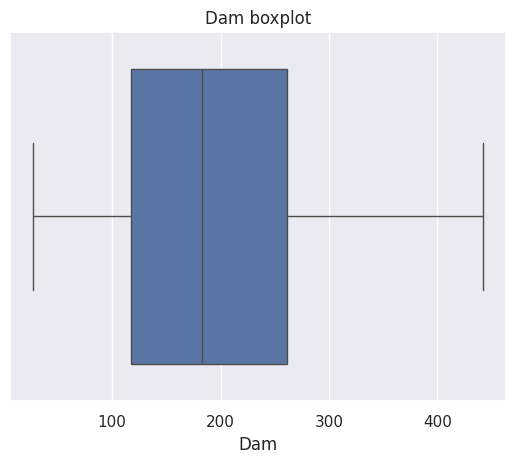

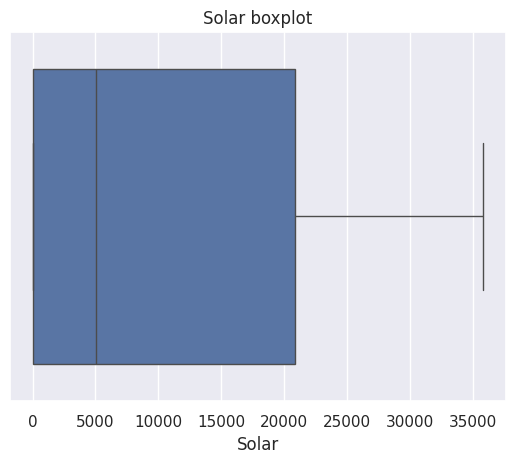

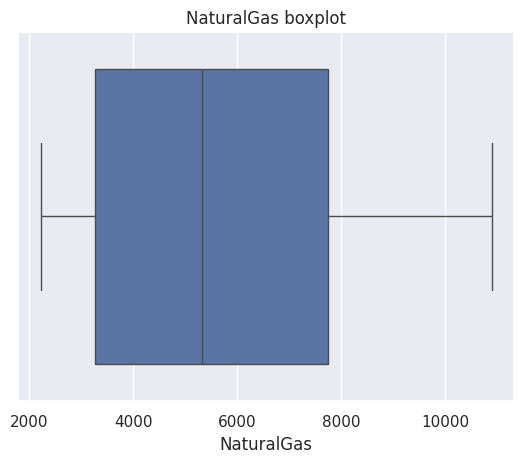

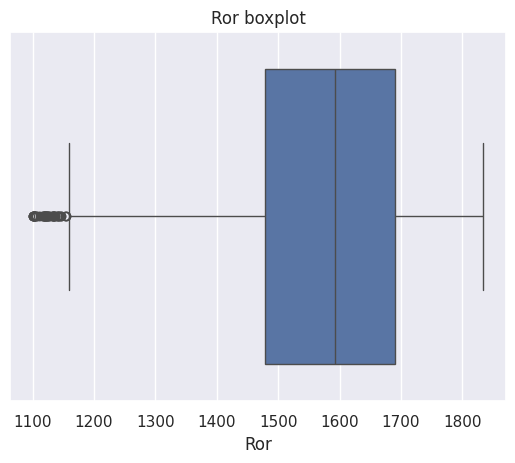

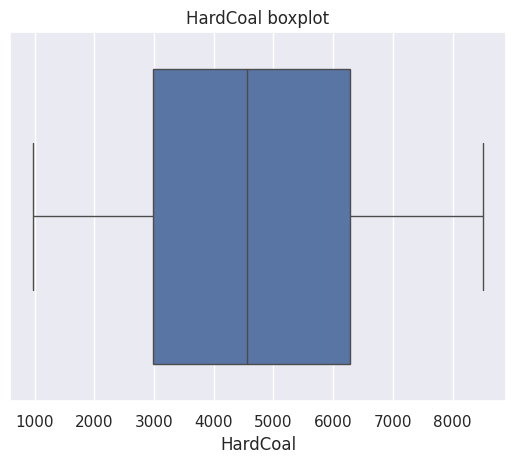

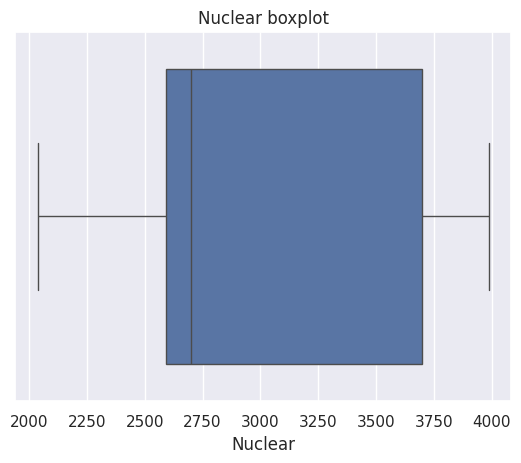

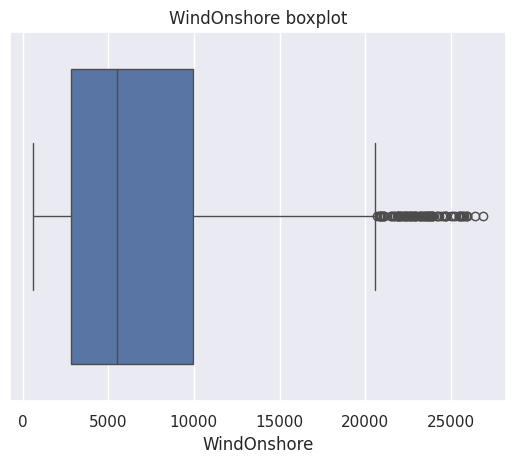

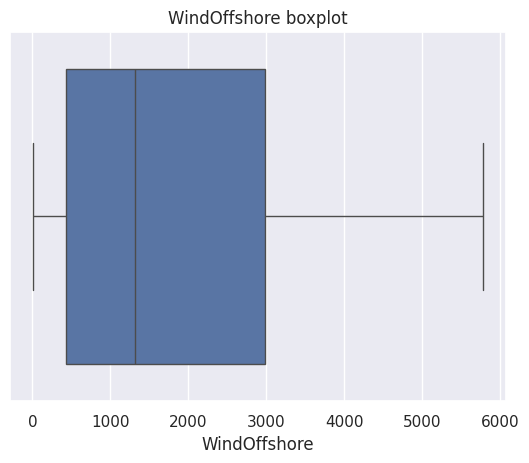

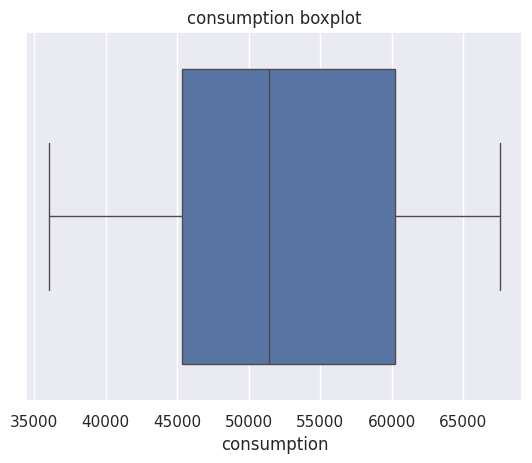

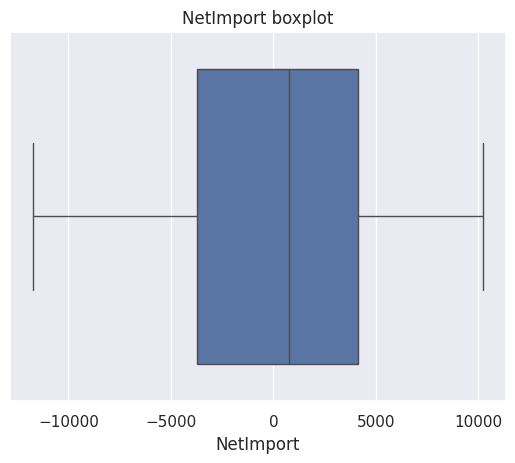

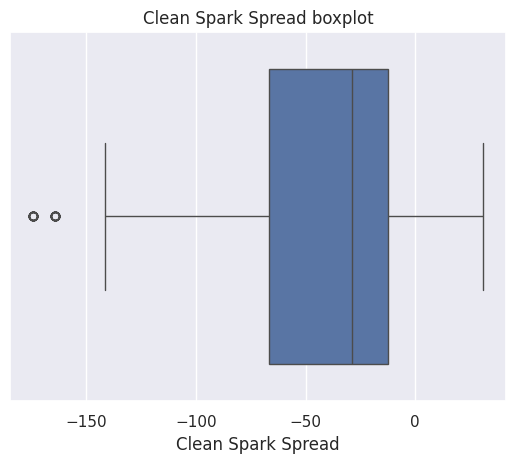

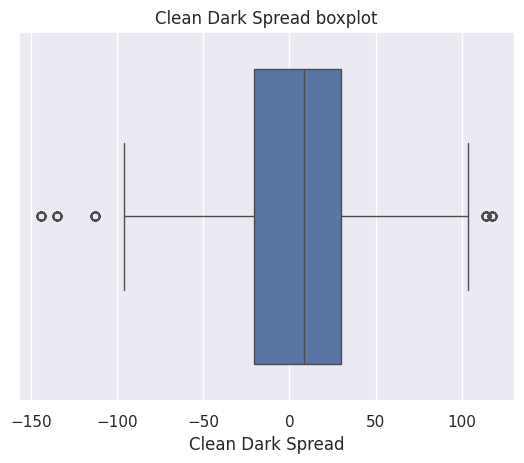

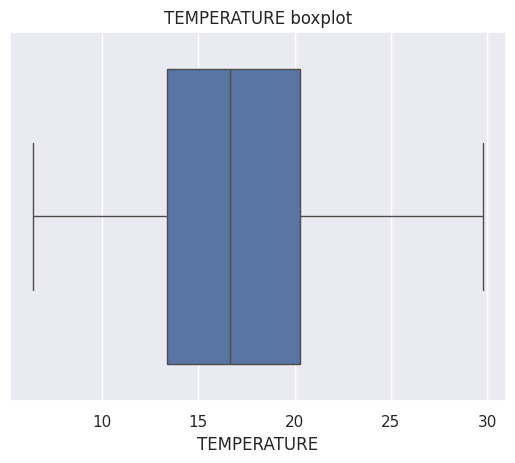

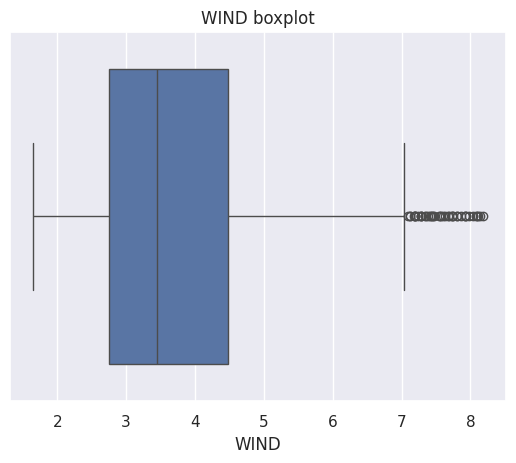

In [ ]:
for i in df_test.columns:
        fig = plt.figure()
        ax = sns.boxplot(x=df_test[i]).set(title=f'{i} boxplot')

In [ ]:
new_data=df_test[important_features]

predictions = rf_important.predict(new_data)
new_data['Predicted Price'] = predictions
new_data

<ipython-input-72-59013ec7290c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Predicted Price'] = predictions


,Clean Dark Spread,Clean Spark Spread,HardCoal,NaturalGas,Nuclear,Ror,NetImport,WIND,consumption,Predicted Price
Date,,,,,,,,,,
2022-05-01 00:00:00+00:00,28.27,-37.98,5513.25,3812.50,3961.50,1146.25,1974.75,2.50,40505.50,189.3167
2022-05-01 01:00:00+00:00,28.27,-37.98,5243.50,3866.75,3962.00,1173.50,1393.00,2.27,38717.00,192.0965
2022-05-01 02:00:00+00:00,28.27,-37.98,5150.50,3753.50,3963.75,1194.00,689.25,2.04,37616.50,180.9657
2022-05-01 03:00:00+00:00,28.27,-37.98,5136.00,3783.00,3964.50,1192.25,664.50,1.66,37067.00,181.8010
2022-05-01 04:00:00+00:00,28.27,-37.98,5143.50,3711.25,3964.75,1197.50,1079.50,1.71,37737.75,181.2129
...,...,...,...,...,...,...,...,...,...,...
2022-06-29 19:00:00+00:00,100.48,-3.41,6982.25,10228.50,3947.00,1602.00,3233.50,3.94,62430.75,275.6401
2022-06-29 20:00:00+00:00,100.48,-3.41,6977.75,10119.25,3946.00,1587.00,4193.75,3.78,59611.25,265.2036
2022-06-29 21:00:00+00:00,100.48,-3.41,7162.75,9233.50,3950.75,1611.50,3327.25,3.64,57529.50,258.3954


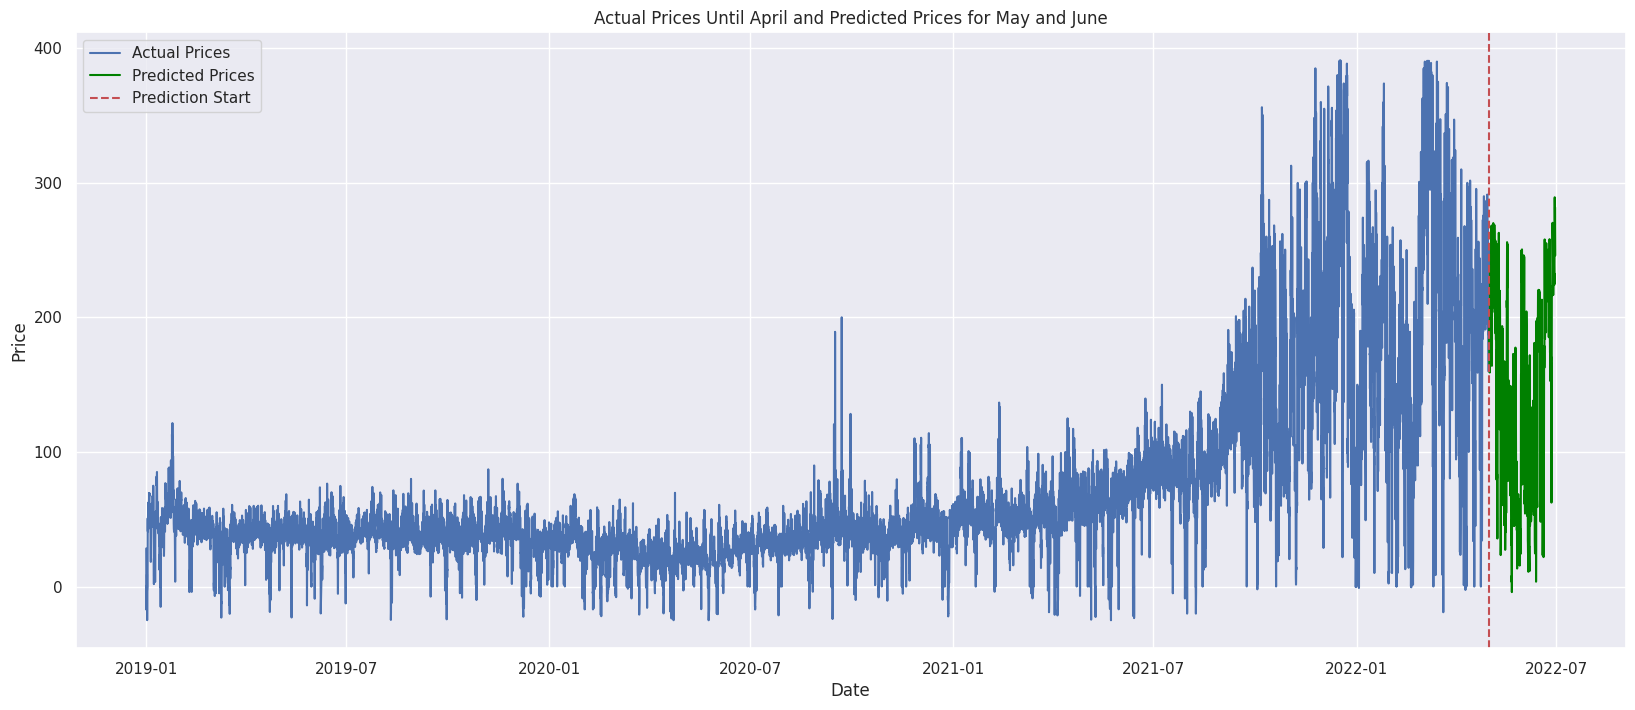

In [ ]:
actual_prices = result_df['price'][:'2022-04-30']
predicted_prices = new_data['Predicted Price']


plt.figure(figsize=(20, 8))
plt.plot(actual_prices.index, actual_prices.values, label='Actual Prices')
plt.plot(predicted_prices.index, predicted_prices.values, label='Predicted Prices',color='green')
plt.axvline(x=pd.to_datetime('2022-05-01'), color='r', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Prices Until April and Predicted Prices for May and June')
plt.legend()
plt.show()